# Predict tags on StackOverflow with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

Data

The following cell will download all data required for this assignment into the folder `week1/data`.

In [1]:
import sys
import os
#!git clone https://github.com/hse-aml/natural-language-processing
sys.path.append("/home/dsxuser/work/natural-language-processing")
import common
sys.path.append("/home/dsxuser/work/natural-language-processing/week1")



In [2]:
 
from common.download_utils import download_week1_resources

download_week1_resources()

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submitting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [3]:
from grader import Grader

In [4]:
grader=Grader()

### Text preprocessing

For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from *nltk*:

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [6]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [7]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [8]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [9]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [10]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_text_prepare* to test it on tiny cases and submit it to Coursera.

In [11]:
import re

In [12]:
import collections
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub('  ',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text =' '.join ([word for word in text.split() if word not in collections.Counter(STOPWORDS)])
    return text

In [13]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [14]:
print(test_text_prepare())

Basic tests are passed.


Run your implementation for questions from file *text_prepare_tests.tsv* to earn the points.

In [15]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)
grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


In [16]:
print(text_prepare_results)

sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date string mysql database timestamp
fill dropdownlist data xml file aspnet application
programmatically trigger jqueryui draggables drag event
get value method argument via reflection java
knockout mapingfromjs observablearray json object data gets lost
facebook connect localhost weird stuff
fullcalendar prev next click
syntaxerror unexpected token
effective way float double comparison
gem install rails fails dns error
listshuttle component richfaces getting updated
laravel responsedownload show images laravel
wrong rspec test
calendar display using java swing
python selenium import regular firefox profile addons
random number 2 variables values
altering http responses firefox extension
start session python web application
align radio buttons horizontally django forms
count number rows sqlite database
wordpress wp_rewrite rules
removing sheet excel 2005 using php
php fatal error function na

Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [17]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [18]:
print(X_train[:3])

['draw stacked dotplot r', 'mysql select records datetime field less specified value', 'terminate windows phone 81 app']


For each tag and for each word calculate how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [19]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

######################################
######### YOUR CODE HERE #############
from nltk.tokenize import regexp_tokenize
from nltk.probability import FreqDist
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
words_counts = FreqDist(word.lower() for title in X_train for sent in title.split() for word in regexp_tokenize(sent,pattern=r"\s|[\.,:']",gaps=True))
tags_counts = FreqDist(tag for sent in y_train for tag in sent)
######################################

[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`. The grader gets the results in the following format (two comma-separated strings with line break):

    tag1,tag2,tag3
    word1,word2,word3

Pay attention that in this assignment you should not submit frequencies or some additional information.

In [20]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))


Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


In [21]:
print('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

WordsTagsCount javascript,c#,java
using,php,java


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [22]:
DICT_SIZE = 5000
######## YOUR CODE HERE ######
wc=words_counts.most_common() 
WORDS_TO_INDEX={ k[0]: wc.index(k) for k in wc}
INDEX_TO_WORDS={v:k for k,v in WORDS_TO_INDEX.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()

In [23]:
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    
    ######################################
    ######### YOUR CODE HERE #############
    for word in text.split():
        try:
            result_vector[words_to_index[word]]+=1
        except:
            print("The word : {} is not in the dictionary".format(word))
    ######################################
    return result_vector

In [24]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [25]:
print(test_my_bag_of_words())

The word : how is not in the dictionary
Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [26]:
from scipy import sparse as sp_sparse

In [27]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

The word : dotplot is not in the dictionary
The word : catalina is not in the dictionary
The word : javalangclasst is not in the dictionary
The word : q_uestion is not in the dictionary
The word : lauch is not in the dictionary
The word : viewwilldisappear is not in the dictionary
The word : zy is not in the dictionary
The word : scipyiosavemat is not in the dictionary
The word : hcommandlink is not in the dictionary
The word : ijsonvalue is not in the dictionary
The word : windowsdatajsonijsonvalue is not in the dictionary
The word : captialisation is not in the dictionary
The word : spinning is not in the dictionary
The word : inputall is not in the dictionary
The word : neterr_connection_refused is not in the dictionary
The word : convertor is not in the dictionary
The word : settimer is not in the dictionary
The word : nondialog is not in the dictionary
The word : indeterminate is not in the dictionary
The word : slidetoggle is not in the dictionary
The word : datastructure is not 

The word : typegettype is not in the dictionary
The word : actionviewmissingtemplate is not in the dictionary
The word : exceptionconverter is not in the dictionary
The word : #anchor is not in the dictionary
The word : locationhash is not in the dictionary
The word : rabbitmqc is not in the dictionary
The word : #2060 is not in the dictionary
The word : svgsvgelement is not in the dictionary
The word : this_getparam is not in the dictionary
The word : rebound is not in the dictionary
The word : err_connection_refused is not in the dictionary
The word : broswer is not in the dictionary
The word : homeaspx is not in the dictionary
The word : nulltype is not in the dictionary
The word : clearinterval is not in the dictionary
The word : onactionexecuting is not in the dictionary
The word : infinitely is not in the dictionary
The word : boostchronotime_point is not in the dictionary
The word : boostchronosteady_clocktime_point is not in the dictionary
The word : iofileio is not in the dict

The word : reverses is not in the dictionary
The word : youre is not in the dictionary
The word : everyday is not in the dictionary
The word : compares is not in the dictionary
The word : 20100910 is not in the dictionary
The word : searched is not in the dictionary
The word : thoroughly is not in the dictionary
The word : pinputmask is not in the dictionary
The word : mask99 is not in the dictionary
The word : 99 is not in the dictionary
The word : 9999 is not in the dictionary
The word : scriptbut is not in the dictionary
The word : postfix is not in the dictionary
The word : order_by is not in the dictionary
The word : methodinvoke is not in the dictionary
The word : htmlactionlink is not in the dictionary
The word : inet_ntoa is not in the dictionary
The word : imagebrush is not in the dictionary
The word : arranging is not in the dictionary
The word : stmtexecute is not in the dictionary
The word : chunked is not in the dictionary
The word : bigo is not in the dictionary
The word 

The word : statistic is not in the dictionary
The word : love is not in the dictionary
The word : distrust is not in the dictionary
The word : unreachable is not in the dictionary
The word : notsupportedexception is not in the dictionary
The word : crypter is not in the dictionary
The word : differs is not in the dictionary
The word : textmodepassword is not in the dictionary
The word : withas is not in the dictionary
The word : balk is not in the dictionary
The word : newtonsoftjsonlinqjarray is not in the dictionary
The word : faking is not in the dictionary
The word : stdvectort is not in the dictionary
The word : dashboardloading is not in the dictionary
The word : stdcin is not in the dictionary
The word : datatemplateselector is not in the dictionary
The word : shget is not in the dictionary
The word : folderpath is not in the dictionary
The word : june is not in the dictionary
The word : cyclic is not in the dictionary
The word : ovveriding is not in the dictionary
The word : ex

The word : intents is not in the dictionary
The word : highscore is not in the dictionary
The word : requied is not in the dictionary
The word : beforeshowday is not in the dictionary
The word : spoiler is not in the dictionary
The word : microsoftjetoledb40 is not in the dictionary
The word : concurrentskiplistset is not in the dictionary
The word : storageframeworkview is not in the dictionary
The word : underlining is not in the dictionary
The word : launch4j is not in the dictionary
The word : messagingexception is not in the dictionary
The word : clientsize is not in the dictionary
The word : postmessage is not in the dictionary
The word : enumvalueof is not in the dictionary
The word : occurence is not in the dictionary
The word : hlapi is not in the dictionary
The word : proportional is not in the dictionary
The word : fblogin is not in the dictionary
The word : arriving is not in the dictionary
The word : uilabels is not in the dictionary
The word : gridsearchcv is not in the d

The word : gnuplot is not in the dictionary
The word : ajenti is not in the dictionary
The word : countbubble is not in the dictionary
The word : insertbefore is not in the dictionary
The word : descriptors is not in the dictionary
The word : assistance is not in the dictionary
The word : sqlite3pp is not in the dictionary
The word : springdatajpa is not in the dictionary
The word : lazyinitializationexception is not in the dictionary
The word : minified is not in the dictionary
The word : uinitialized is not in the dictionary
The word : basecontroller is not in the dictionary
The word : divided is not in the dictionary
The word : hudson is not in the dictionary
The word : coloumn is not in the dictionary
The word : bootstrapselect is not in the dictionary
The word : richtab is not in the dictionary
The word : rerender is not in the dictionary
The word : rerender is not in the dictionary
The word : richtab is not in the dictionary
The word : intel is not in the dictionary
The word : xd

The word : xdocumentdescendants is not in the dictionary
The word : somethinghere is not in the dictionary
The word : cities is not in the dictionary
The word : europe is not in the dictionary
The word : geocode is not in the dictionary
The word : messege is not in the dictionary
The word : kinds is not in the dictionary
The word : antlr is not in the dictionary
The word : decoupling is not in the dictionary
The word : __php_incomplete_class is not in the dictionary
The word : dns_get_record is not in the dictionary
The word : crypto is not in the dictionary
The word : stderr is not in the dictionary
The word : numpymean is not in the dictionary
The word : ++i is not in the dictionary
The word : treevew is not in the dictionary
The word : quantifier is not in the dictionary
The word : essential is not in the dictionary
The word : mutual is not in the dictionary
The word : 2way is not in the dictionary
The word : kb is not in the dictionary
The word : listkeyvaluepairstring is not in th

The word : drf is not in the dictionary
The word : nestedfields is not in the dictionary
The word : list_filter is not in the dictionary
The word : nonarc is not in the dictionary
The word : slave is not in the dictionary
The word : jwindow is not in the dictionary
The word : jwindow is not in the dictionary
The word : syntaxerrorexception is not in the dictionary
The word : datatablecompute is not in the dictionary
The word : systemwindowsinteractivity is not in the dictionary
The word : hell is not in the dictionary
The word : myvar is not in the dictionary
The word : eaddrinuse is not in the dictionary
The word : blinking is not in the dictionary
The word : readprocessmemory is not in the dictionary
The word : jenkin is not in the dictionary
The word : sketch is not in the dictionary
The word : listtype is not in the dictionary
The word : golang is not in the dictionary
The word : structuring is not in the dictionary
The word : wednesday is not in the dictionary
The word : asprepeat

The word : iserror is not in the dictionary
The word : documentlocation is not in the dictionary
The word : webappcontext is not in the dictionary
The word : extraclasspath is not in the dictionary
The word : stringmatches is not in the dictionary
The word : vowel is not in the dictionary
The word : iserializable is not in the dictionary
The word : senders is not in the dictionary
The word : sysgetsizeof is not in the dictionary
The word : unreasonably is not in the dictionary
The word : geting is not in the dictionary
The word : emitted is not in the dictionary
The word : 101 is not in the dictionary
The word : neterr_connection_reset is not in the dictionary
The word : iterables is not in the dictionary
The word : enterprise is not in the dictionary
The word : seeking is not in the dictionary
The word : threadclass is not in the dictionary
The word : divstyleleft is not in the dictionary
The word : divstyletop is not in the dictionary
The word : opencvs is not in the dictionary
The w

The word : inputstreamreader is not in the dictionary
The word : isdate is not in the dictionary
The word : ps is not in the dictionary
The word : macrolike is not in the dictionary
The word : metaprogramming is not in the dictionary
The word : qimage is not in the dictionary
The word : comgooglegsongson is not in the dictionary
The word : eventsources is not in the dictionary
The word : rlapackdll is not in the dictionary
The word : recycler is not in the dictionary
The word : mysqlperformance is not in the dictionary
The word : orgspringframeworkbeansfactorybeandefinitionstoreexception is not in the dictionary
The word : tabitems is not in the dictionary
The word : posixlt is not in the dictionary
The word : 79ffee24 is not in the dictionary
The word : 80131506 is not in the dictionary
The word : xmldomminidomparse is not in the dictionary
The word : webbased is not in the dictionary
The word : iterates is not in the dictionary
The word : v031 is not in the dictionary
The word : wind

The word : javaiobufferedreaderclose is not in the dictionary
The word : mouseclicks is not in the dictionary
The word : doublelinked is not in the dictionary
The word : downloadfilecompleted is not in the dictionary
The word : downloadprogresschanged is not in the dictionary
The word : orghibernatehqlastquerysyntaxexception is not in the dictionary
The word : nondelegate is not in the dictionary
The word : stars is not in the dictionary
The word : 490 is not in the dictionary
The word : familiar is not in the dictionary
The word : windowaddeventlistener is not in the dictionary
The word : syncdb is not in the dictionary
The word : autoresize is not in the dictionary
The word : ex19c9510 is not in the dictionary
The word : ought is not in the dictionary
The word : ctime is not in the dictionary
The word : throttling is not in the dictionary
The word : spawned is not in the dictionary
The word : localizeddescription is not in the dictionary
The word : elemmatch is not in the dictionary


The word : geom_line is not in the dictionary
The word : anchorpane is not in the dictionary
The word : errorproviderclear is not in the dictionary
The word : preceded is not in the dictionary
The word : multple is not in the dictionary
The word : cforeach is not in the dictionary
The word : scriptlet is not in the dictionary
The word : rebuild is not in the dictionary
The word : pch is not in the dictionary
The word : webclientdownloadstring is not in the dictionary
The word : isodate is not in the dictionary
The word : nonangular is not in the dictionary
The word : prcomp is not in the dictionary
The word : orgrefelections is not in the dictionary
The word : boostregex_search is not in the dictionary
The word : wstring is not in the dictionary
The word : orghibernateexceptionjdbcconnectionexception is not in the dictionary
The word : upgradeutil is not in the dictionary
The word : autorefresh is not in the dictionary
The word : gsp is not in the dictionary
The word : returnurl is not

The word : linkify is not in the dictionary
The word : selflocation is not in the dictionary
The word : requestdispatcher is not in the dictionary
The word : accomplish is not in the dictionary
The word : unflattening is not in the dictionary
The word : xl is not in the dictionary
The word : rights is not in the dictionary
The word : gridstackjs is not in the dictionary
The word : orequals is not in the dictionary
The word : accounting is not in the dictionary
The word : quirks is not in the dictionary
The word : postfields is not in the dictionary
The word : contextmenustrip is not in the dictionary
The word : unordered_maptiterator is not in the dictionary
The word : afxpumpmessage is not in the dictionary
The word : titleforheaderinsection is not in the dictionary
The word : stringwithformat is not in the dictionary
The word : request_uri is not in the dictionary
The word : errordocument is not in the dictionary
The word : uglify is not in the dictionary
The word : jeditorpane is no

The word : survey is not in the dictionary
The word : earlier is not in the dictionary
The word : higherlevel is not in the dictionary
The word : constructs is not in the dictionary
The word : easier is not in the dictionary
The word : flows is not in the dictionary
The word : springbatch is not in the dictionary
The word : teardown is not in the dictionary
The word : formsauthenticationformscookiepath is not in the dictionary
The word : collectionviewsourceview is not in the dictionary
The word : mailaddress is not in the dictionary
The word : touchevent is not in the dictionary
The word : mails is not in the dictionary
The word : settemplate is not in the dictionary
The word : simplewire is not in the dictionary
The word : crashed is not in the dictionary
The word : rr is not in the dictionary
The word : mockinstance_of is not in the dictionary
The word : any_instance is not in the dictionary
The word : bitmapdata is not in the dictionary
The word : nsbitmapimagerep is not in the dic

The word : indentationerror is not in the dictionary
The word : testcase is not in the dictionary
The word : matplot is not in the dictionary
The word : tabpanel is not in the dictionary
The word : taskexecutor is not in the dictionary
The word : taskscheduler is not in the dictionary
The word : picke is not in the dictionary
The word : childpage is not in the dictionary
The word : listasenumerable is not in the dictionary
The word : unquoted is not in the dictionary
The word : imagetkphotoimage is not in the dictionary
The word : 600x600 is not in the dictionary
The word : crosscompiling is not in the dictionary
The word : armv6l is not in the dictionary
The word : armlinuxgnueabigcc is not in the dictionary
The word : rxjavas is not in the dictionary
The word : table2exceljs is not in the dictionary
The word : ispostback is not in the dictionary
The word : webbrowsr is not in the dictionary
The word : unsorted is not in the dictionary
The word : mailr is not in the dictionary
The wor

The word : qualifier is not in the dictionary
The word : redundant is not in the dictionary
The word : get_range is not in the dictionary
The word : value2 is not in the dictionary
The word : maxlength is not in the dictionary
The word : executions is not in the dictionary
The word : destroyall is not in the dictionary
The word : exampleitemfragment is not in the dictionary
The word : fcollection_select is not in the dictionary
The word : 0x40 is not in the dictionary
The word : cleartripcom is not in the dictionary
The word : testcases is not in the dictionary
The word : 105 is not in the dictionary
The word : suffixes is not in the dictionary
The word : datatablesnet is not in the dictionary
The word : singleline is not in the dictionary
The word : jmsmanagedconnectionfactoryimpl is not in the dictionary
The word : javaxjmsconnectionfactory is not in the dictionary
The word : stackfrombottom is not in the dictionary
The word : my_thread_global_end is not in the dictionary
The word : 

The word : marathi is not in the dictionary
The word : stringgetbytes is not in the dictionary
The word : flowing is not in the dictionary
The word : zenddbadapter is not in the dictionary
The word : gtk# is not in the dictionary
The word : overide is not in the dictionary
The word : stringforkey is not in the dictionary
The word : nsnull is not in the dictionary
The word : static_assert is not in the dictionary
The word : nonvirtual is not in the dictionary
The word : restrictions is not in the dictionary
The word : represents is not in the dictionary
The word : filealreadyexistsexception is not in the dictionary
The word : saveastextfile is not in the dictionary
The word : toast is not in the dictionary
The word : accumulation is not in the dictionary
The word : datetimeticks is not in the dictionary
The word : datetimetimeofday is not in the dictionary
The word : rightmost is not in the dictionary
The word : authorised is not in the dictionary
The word : fatalerrorexception is not i

The word : qscrollarea is not in the dictionary
The word : modelling is not in the dictionary
The word : indefinitelyrecurring is not in the dictionary
The word : calendarlike is not in the dictionary
The word : uniqueentity is not in the dictionary
The word : collected is not in the dictionary
The word : signs is not in the dictionary
The word : ndarray is not in the dictionary
The word : annotationdriven is not in the dictionary
The word : rtsp is not in the dictionary
The word : bitmapframe is not in the dictionary
The word : selftableviewreloaddata is not in the dictionary
The word : sparce is not in the dictionary
The word : numberformatexception is not in the dictionary
The word : thisip_address is not in the dictionary
The word : httpservletrequest#getremoteaddr is not in the dictionary
The word : cipherinit is not in the dictionary
The word : weighted is not in the dictionary
The word : tablesorter is not in the dictionary
The word : #htmldocument is not in the dictionary
The w

The word : s+ is not in the dictionary
The word : lambdaconversionexception is not in the dictionary
The word : utilproperties is not in the dictionary
The word : systemwebuidesign is not in the dictionary
The word : instantiateviewcontrollerwithidentifier is not in the dictionary
The word : isolatedstoragefile is not in the dictionary
The word : isolatedstoragefilestream is not in the dictionary
The word : iff is not in the dictionary
The word : fcm is not in the dictionary
The word : 166 is not in the dictionary
The word : __definegetter__ is not in the dictionary
The word : serialisation is not in the dictionary
The word : c2248 is not in the dictionary
The word : cobjectcobject is not in the dictionary
The word : cobject is not in the dictionary
The word : newtonsoft is not in the dictionary
The word : transportclient is not in the dictionary
The word : sysstdinread is not in the dictionary
The word : consistently is not in the dictionary
The word : recognizer is not in the diction

The word : triplet is not in the dictionary
The word : systemwebui is not in the dictionary
The word : regasm is not in the dictionary
The word : explorerexe is not in the dictionary
The word : metamodel is not in the dictionary
The word : abcxyz is not in the dictionary
The word : plupload is not in the dictionary
The word : switcher is not in the dictionary
The word : ienumerablekeyvaluepairstring is not in the dictionary
The word : coefficient is not in the dictionary
The word : checkboxs is not in the dictionary
The word : elemeny is not in the dictionary
The word : lags is not in the dictionary
The word : anagram is not in the dictionary
The word : prefixes is not in the dictionary
The word : indigo is not in the dictionary
The word : ontouchmove is not in the dictionary
The word : touched is not in the dictionary
The word : ossystem is not in the dictionary
The word : substitute is not in the dictionary
The word : rowdatabound is not in the dictionary
The word : authcomponentlogi

The word : hood is not in the dictionary
The word : commitallowingstateloss is not in the dictionary
The word : syncfs is not in the dictionary
The word : waits is not in the dictionary
The word : disc is not in the dictionary
The word : slots is not in the dictionary
The word : requiredfieldvalidator is not in the dictionary
The word : marshallergetnode is not in the dictionary
The word : splitcontainer is not in the dictionary
The word : bouncycastle is not in the dictionary
The word : activatorcreateinstance is not in the dictionary
The word : activatorcreateinstancet is not in the dictionary
The word : diffrent is not in the dictionary
The word : standardinput is not in the dictionary
The word : acm is not in the dictionary
The word : 10038 is not in the dictionary
The word : jolly is not in the dictionary
The word : jumpers is not in the dictionary
The word : escapejs is not in the dictionary
The word : vkcom is not in the dictionary
The word : nethttppost_form is not in the dicti

The word : systemdiagnosticsprocess is not in the dictionary
The word : phonenumber is not in the dictionary
The word : c1083 is not in the dictionary
The word : opencv2 is not in the dictionary
The word : corehpp is not in the dictionary
The word : sanitation is not in the dictionary
The word : vbox is not in the dictionary
The word : vlookup is not in the dictionary
The word : formulas is not in the dictionary
The word : sxssfworkbook is not in the dictionary
The word : multiparameter is not in the dictionary
The word : sideeffect is not in the dictionary
The word : hacker is not in the dictionary
The word : proofing is not in the dictionary
The word : redistemplate is not in the dictionary
The word : opsforvalue is not in the dictionary
The word : valueoperations is not in the dictionary
The word : stdarray is not in the dictionary
The word : snaps is not in the dictionary
The word : mouseup is not in the dictionary
The word : 504 is not in the dictionary
The word : php+framework is

The word : slack is not in the dictionary
The word : javautilregexpatternsyntaxexception is not in the dictionary
The word : sax is not in the dictionary
The word : wellformed is not in the dictionary
The word : dbseed is not in the dictionary
The word : singletons is not in the dictionary
The word : ifstructure is not in the dictionary
The word : classifierpredict is not in the dictionary
The word : acode is not in the dictionary
The word : xlibh is not in the dictionary
The word : toolstrip is not in the dictionary
The word : sselect is not in the dictionary
The word : lable is not in the dictionary
The word : javanetmalformedurlexception is not in the dictionary
The word : kcfinder is not in the dictionary
The word : fk is not in the dictionary
The word : palettes is not in the dictionary
The word : distinguishable is not in the dictionary
The word : bw is not in the dictionary
The word : exponents is not in the dictionary
The word : skscene is not in the dictionary
The word : canca

The word : linkedblockingqueue is not in the dictionary
The word : concurrentlinkedqueue is not in the dictionary
The word : spent is not in the dictionary
The word : socket_connect is not in the dictionary
The word : functionsocketconnect is not in the dictionary
The word : xxxso is not in the dictionary
The word : arraylistcomparable is not in the dictionary
The word : systemtimeoutexception is not in the dictionary
The word : mscorlibdll is not in the dictionary
The word : djangodbutilsdatabaseerror is not in the dictionary
The word : discretization is not in the dictionary
The word : chosenjqueryjs is not in the dictionary
The word : debugprint is not in the dictionary
The word : mondors is not in the dictionary
The word : mscaptcha is not in the dictionary
The word : httphandler is not in the dictionary
The word : incident is not in the dictionary
The word : unabletocompleteexception is not in the dictionary
The word : icloud is not in the dictionary
The word : fresh is not in the

The word : health is not in the dictionary
The word : guitext is not in the dictionary
The word : apply_along_axis is not in the dictionary
The word : visualize is not in the dictionary
The word : companys is not in the dictionary
The word : follower is not in the dictionary
The word : reponse is not in the dictionary
The word : menubar is not in the dictionary
The word : iboutlet is not in the dictionary
The word : nonajax is not in the dictionary
The word : cllocationmanagerauthorizationstatus is not in the dictionary
The word : clauthorizationstatusnotdetermined is not in the dictionary
The word : swiftobjc is not in the dictionary
The word : parsererror is not in the dictionary
The word : watermark is not in the dictionary
The word : extender is not in the dictionary
The word : echos is not in the dictionary
The word : gige is not in the dictionary
The word : vision is not in the dictionary
The word : detailed is not in the dictionary
The word : dataflow is not in the dictionary
Th

The word : oraclejdbcdrivert4cconnectionisvalid is not in the dictionary
The word : systemoutprintln is not in the dictionary
The word : timespec is not in the dictionary
The word : nanoseconds is not in the dictionary
The word : tv_nsec is not in the dictionary
The word : responsewrapper is not in the dictionary
The word : cgiescapehtml is not in the dictionary
The word : qheaderview is not in the dictionary
The word : qtablewidget is not in the dictionary
The word : javaiostreamcorruptedexception is not in the dictionary
The word : troubleshoot is not in the dictionary
The word : mercurial is not in the dictionary
The word : hg is not in the dictionary
The word : modelobjectsget is not in the dictionary
The word : epoll_pwait is not in the dictionary
The word : urlstreamhandler is not in the dictionary
The word : pixelbypixel is not in the dictionary
The word : faults is not in the dictionary
The word : numberofsectionsintableview is not in the dictionary
The word : prerequisites is 

The word : angles is not in the dictionary
The word : file_get_html is not in the dictionary
The word : javaattachment is not in the dictionary
The word : orgpostgresqldriver is not in the dictionary
The word : mini is not in the dictionary
The word : tomcat7 is not in the dictionary
The word : gai is not in the dictionary
The word : qtcpsockets is not in the dictionary
The word : informing is not in the dictionary
The word : accountlock is not in the dictionary
The word : dopostback is not in the dictionary
The word : capturestackbacktrace is not in the dictionary
The word : rewriterule is not in the dictionary
The word : scrollleft is not in the dictionary
The word : sadly is not in the dictionary
The word : vis is not in the dictionary
The word : questionbasic is not in the dictionary
The word : backgroundposition is not in the dictionary
The word : permalinks is not in the dictionary
The word : scalability is not in the dictionary
The word : javanio is not in the dictionary
The wor

The word : cmapcmgray is not in the dictionary
The word : iuseremailstore is not in the dictionary
The word : studios is not in the dictionary
The word : localhost8983 is not in the dictionary
The word : producerconsumer is not in the dictionary
The word : theory is not in the dictionary
The word : test_coredataappdelegate is not in the dictionary
The word : xelementtostring is not in the dictionary
The word : systemoutofmemoryexception is not in the dictionary
The word : centre is not in the dictionary
The word : vnc is not in the dictionary
The word : lgpl is not in the dictionary
The word : mit is not in the dictionary
The word : whiele is not in the dictionary
The word : textvalue is not in the dictionary
The word : pdo_mysql is not in the dictionary
The word : set_message is not in the dictionary
The word : binds is not in the dictionary
The word : dataloadingtext is not in the dictionary
The word : tld is not in the dictionary
The word : facebookgetsession is not in the dictionar

The word : ib is not in the dictionary
The word : cleared is not in the dictionary
The word : likelihood is not in the dictionary
The word : estimator is not in the dictionary
The word : tax is not in the dictionary
The word : guest is not in the dictionary
The word : ellipsoid is not in the dictionary
The word : energy is not in the dictionary
The word : ipa is not in the dictionary
The word : modifies is not in the dictionary
The word : splitcontainer is not in the dictionary
The word : bordercontainer is not in the dictionary
The word : ssl_error_protocol_version_alert is not in the dictionary
The word : iniitializing is not in the dictionary
The word : objwritersave is not in the dictionary
The word : jtablegetselectedrow is not in the dictionary
The word : cer is not in the dictionary
The word : computation is not in the dictionary
The word : listinterface is not in the dictionary
The word : hasclass is not in the dictionary
The word : bullet is not in the dictionary
The word : 36

The word : uiclearcolor is not in the dictionary
The word : boostassign is not in the dictionary
The word : aliasing is not in the dictionary
The word : myappcertificatecrt is not in the dictionary
The word : cacert is not in the dictionary
The word : cacert is not in the dictionary
The word : winxp is not in the dictionary
The word : winxp is not in the dictionary
The word : ime is not in the dictionary
The word : embeding is not in the dictionary
The word : imagettftext is not in the dictionary
The word : jsonutilityfromjson is not in the dictionary
The word : itms is not in the dictionary
The word : ifelseif is not in the dictionary
The word : ladder is not in the dictionary
The word : phpsessid is not in the dictionary
The word : grape is not in the dictionary
The word : shadowing is not in the dictionary
The word : windowlocationhref is not in the dictionary
The word : basichttpbinding is not in the dictionary
The word : datatablerows is not in the dictionary
The word : repond is 

The word : djangocorepaginator is not in the dictionary
The word : albums is not in the dictionary
The word : tiff is not in the dictionary
The word : constantsstring is not in the dictionary
The word : fselect is not in the dictionary
The word : supersized is not in the dictionary
The word : preprinted is not in the dictionary
The word : sp1 is not in the dictionary
The word : battery is not in the dictionary
The word : battery is not in the dictionary
The word : savez is not in the dictionary
The word : sudo is not in the dictionary
The word : 0321 is not in the dictionary
The word : claidehelp is not in the dictionary
The word : heightforrowatindexpath is not in the dictionary
The word : ibinspectable is not in the dictionary
The word : oneliner is not in the dictionary
The word : bufferedreaderreadline is not in the dictionary
The word : grade is not in the dictionary
The word : grade is not in the dictionary
The word : alchemy is not in the dictionary
The word : jshint is not in t

The word : apachecommons is not in the dictionary
The word : javalangstringindexoutofboundsexception is not in the dictionary
The word : instantiateviewcontrollerwithidentifier is not in the dictionary
The word : performseguewithidentifier is not in the dictionary
The word : 9009 is not in the dictionary
The word : fstream is not in the dictionary
The word : provides is not in the dictionary
The word : variation is not in the dictionary
The word : nvarchar is not in the dictionary
The word : checkmark is not in the dictionary
The word : visualizations is not in the dictionary
The word : nsurlsession is not in the dictionary
The word : nsurlresponse is not in the dictionary
The word : craziness is not in the dictionary
The word : deeply is not in the dictionary
The word : opensuse is not in the dictionary
The word : mainjs is not in the dictionary
The word : pluginsjs is not in the dictionary
The word : priorityqueue is not in the dictionary
The word : kb is not in the dictionary
The wo

The word : getwindowhandles is not in the dictionary
The word : webdriverjs is not in the dictionary
The word : coercing is not in the dictionary
The word : companies is not in the dictionary
The word : waitall is not in the dictionary
The word : systemdrawing is not in the dictionary
The word : orghibernateexceptiongenericjdbcexception is not in the dictionary
The word : canonot is not in the dictionary
The word : boostasioipmulticastjoin_group is not in the dictionary
The word : domnodelist is not in the dictionary
The word : pcolormesh is not in the dictionary
The word : gnu is not in the dictionary
The word : makefiles is not in the dictionary
The word : logstash is not in the dictionary
The word : windowparent is not in the dictionary
The word : windowtop is not in the dictionary
The word : contenttypes is not in the dictionary
The word : issuing is not in the dictionary
The word : t_encapsed_and_whitespace is not in the dictionary
The word : connectiontimeout is not in the dictio

The word : slidedown is not in the dictionary
The word : slideup is not in the dictionary
The word : __new__ is not in the dictionary
The word : constellation is not in the dictionary
The word : sampling is not in the dictionary
The word : occupy is not in the dictionary
The word : ninjaide is not in the dictionary
The word : thought is not in the dictionary
The word : applicationhtmlerb is not in the dictionary
The word : pwc3990 is not in the dictionary
The word : getwriter is not in the dictionary
The word : stdstringc_str is not in the dictionary
The word : collapsed is not in the dictionary
The word : booleans is not in the dictionary
The word : filezilla is not in the dictionary
The word : resolves is not in the dictionary
The word : formcheckbox is not in the dictionary
The word : caches is not in the dictionary
The word : newsletter is not in the dictionary
The word : xmailer is not in the dictionary
The word : snippets is not in the dictionary
The word : perror is not in the d

The word : netbios is not in the dictionary
The word : typeconverter is not in the dictionary
The word : listlike is not in the dictionary
The word : filterchainproxy is not in the dictionary
The word : node_save is not in the dictionary
The word : multitasking is not in the dictionary
The word : modus is not in the dictionary
The word : modus is not in the dictionary
The word : watchfile is not in the dictionary
The word : dialect is not in the dictionary
The word : paranoia is not in the dictionary
The word : reversal is not in the dictionary
The word : trays is not in the dictionary
The word : defaultrestriction is not in the dictionary
The word : entitybean is not in the dictionary
The word : xmlnodelistselectsinglenode is not in the dictionary
The word : jquerygetscript is not in the dictionary
The word : simpledateformatparse is not in the dictionary
The word : gettime is not in the dictionary
The word : date_created is not in the dictionary
The word : int_ is not in the dictiona

The word : lm is not in the dictionary
The word : rnet is not in the dictionary
The word : profiles is not in the dictionary
The word : scriptmanagerregisterstartupscript is not in the dictionary
The word : timeframe is not in the dictionary
The word : inspector is not in the dictionary
The word : nanosecond is not in the dictionary
The word : c++s is not in the dictionary
The word : pools is not in the dictionary
The word : array_udiff is not in the dictionary
The word : 0x00000000 is not in the dictionary
The word : itemsproperty is not in the dictionary
The word : createnativequery is not in the dictionary
The word : nonentity is not in the dictionary
The word : locals is not in the dictionary
The word : requestinput is not in the dictionary
The word : inputget is not in the dictionary
The word : reacts is not in the dictionary
The word : functioning is not in the dictionary
The word : include_once is not in the dictionary
The word : pep358 is not in the dictionary
The word : httpco

The word : manytomanyfields is not in the dictionary
The word : defaultconstructor is not in the dictionary
The word : reinterpret_castint is not in the dictionary
The word : static_castint is not in the dictionary
The word : static_castvoid is not in the dictionary
The word : bytea is not in the dictionary
The word : bank is not in the dictionary
The word : errorexecution is not in the dictionary
The word : execexception is not in the dictionary
The word : cprogram is not in the dictionary
The word : filesjavajdk170_79binjavaexe is not in the dictionary
The word : setautoresizingmask is not in the dictionary
The word : php_memcachedll is not in the dictionary
The word : 524 is not in the dictionary
The word : python35 is not in the dictionary
The word : jsondumps is not in the dictionary
The word : guidance is not in the dictionary
The word : hung is not in the dictionary
The word : filesize is not in the dictionary
The word : cutoff is not in the dictionary
The word : foundation_expo

The word : print_thumbnail is not in the dictionary
The word : php53 is not in the dictionary
The word : sitecore is not in the dictionary
The word : qfilesystemwatcher is not in the dictionary
The word : emits is not in the dictionary
The word : directorychanged is not in the dictionary
The word : hasp is not in the dictionary
The word : correlations is not in the dictionary
The word : _iotextiowrapper is not in the dictionary
The word : subscriptable is not in the dictionary
The word : checkbuilt is not in the dictionary
The word : gift is not in the dictionary
The word : cgrectintegral is not in the dictionary
The word : parsergenerator is not in the dictionary
The word : jdbcodbcdriver is not in the dictionary
The word : headphone is not in the dictionary
The word : jack is not in the dictionary
The word : blogs is not in the dictionary
The word : jekyll is not in the dictionary
The word : initwithcoder is not in the dictionary
The word : getactionbar is not in the dictionary
The w

The word : traces is not in the dictionary
The word : historypushstate is not in the dictionary
The word : datareader is not in the dictionary
The word : bgr is not in the dictionary
The word : pcalendar is not in the dictionary
The word : pdatatable is not in the dictionary
The word : pajax is not in the dictionary
The word : dateselect is not in the dictionary
The word : circumvent is not in the dictionary
The word : thislock is not in the dictionary
The word : passbyreference is not in the dictionary
The word : 430final is not in the dictionary
The word : 143release is not in the dictionary
The word : action_refresh is not in the dictionary
The word : nonhierarchical is not in the dictionary
The word : strategies is not in the dictionary
The word : overflowerror is not in the dictionary
The word : infinity is not in the dictionary
The word : r4ds is not in the dictionary
The word : capability is not in the dictionary
The word : 10054 is not in the dictionary
The word : wsaeconnreset

The word : disadvantage is not in the dictionary
The word : aliases is not in the dictionary
The word : trustmanager is not in the dictionary
The word : warp is not in the dictionary
The word : tosuccesscallbackstring is not in the dictionary
The word : writejavascript is not in the dictionary
The word : netscp is not in the dictionary
The word : nodegooglemaps is not in the dictionary
The word : atob is not in the dictionary
The word : btoa is not in the dictionary
The word : sessrun is not in the dictionary
The word : tfglobal_variables_initializer is not in the dictionary
The word : stringnpos is not in the dictionary
The word : ctrl_c is not in the dictionary
The word : sigint is not in the dictionary
The word : datamining is not in the dictionary
The word : inspite is not in the dictionary
The word : ie6 is not in the dictionary
The word : consists is not in the dictionary
The word : adapt is not in the dictionary
The word : vsphere is not in the dictionary
The word : esxi is not 

The word : autopostback is not in the dictionary
The word : discord is not in the dictionary
The word : python+mongodb is not in the dictionary
The word : gridfs is not in the dictionary
The word : channelread is not in the dictionary
The word : customisation is not in the dictionary
The word : renegotiation is not in the dictionary
The word : delegating is not in the dictionary
The word : accordingly is not in the dictionary
The word : gettickcount is not in the dictionary
The word : _win64 is not in the dictionary
The word : resultsetgetstring is not in the dictionary
The word : colname is not in the dictionary
The word : topdow is not in the dictionary
The word : road is not in the dictionary
The word : warpperspective is not in the dictionary
The word : multiprocessingpoolmap is not in the dictionary
The word : answers is not in the dictionary
The word : sqldatareader is not in the dictionary
The word : variance is not in the dictionary
The word : _id is not in the dictionary
The w

The word : getconstructor is not in the dictionary
The word : nosuchmethodexception is not in the dictionary
The word : wellformed is not in the dictionary
The word : intermittent is not in the dictionary
The word : _ah is not in the dictionary
The word : openid_verify is not in the dictionary
The word : ord is not in the dictionary
The word : orgcodehausjacksonjsongenerationexception is not in the dictionary
The word : indirectly is not in the dictionary
The word : javase is not in the dictionary
The word : javaee is not in the dictionary
The word : overflowing is not in the dictionary
The word : fallthrough is not in the dictionary
The word : scaffoldcss is not in the dictionary
The word : jplayer is not in the dictionary
The word : linearsvc is not in the dictionary
The word : virtualization is not in the dictionary
The word : deselecting is not in the dictionary
The word : vanilla is not in the dictionary
The word : h1 is not in the dictionary
The word : filterdispatcher is not in 

The word : zendsearchlucenelucene is not in the dictionary
The word : zendframework2 is not in the dictionary
The word : viewphtml is not in the dictionary
The word : 1702 is not in the dictionary
The word : loosing is not in the dictionary
The word : desc is not in the dictionary
The word : logins is not in the dictionary
The word : contacted is not in the dictionary
The word : didfinishlaunchingwithoptions is not in the dictionary
The word : promisethen is not in the dictionary
The word : cutting is not in the dictionary
The word : check_auth_continue is not in the dictionary
The word : 504 is not in the dictionary
The word : 574 is not in the dictionary
The word : netsmtpsyntaxerror is not in the dictionary
The word : multidisplay is not in the dictionary
The word : signup is not in the dictionary
The word : aob is not in the dictionary
The word : setfilterqueryprovider is not in the dictionary
The word : probabilistic is not in the dictionary
The word : httpput is not in the dictio

The word : commenting is not in the dictionary
The word : urlpatterns is not in the dictionary
The word : switchpreference is not in the dictionary
The word : onchecked is not in the dictionary
The word : autoincrement is not in the dictionary
The word : httpclientpostasync is not in the dictionary
The word : skspritenode is not in the dictionary
The word : sknode is not in the dictionary
The word : mainthread is not in the dictionary
The word : cups is not in the dictionary
The word : javaxprint is not in the dictionary
The word : nslocale is not in the dictionary
The word : preferredlanguages is not in the dictionary
The word : standarduserdefaults is not in the dictionary
The word : objectforkey is not in the dictionary
The word : applelanguages is not in the dictionary
The word : datamember is not in the dictionary
The word : systemnetmailsmtpexception is not in the dictionary
The word : 215 is not in the dictionary
The word : ipod is not in the dictionary
The word : persistentid i

The word : imagick is not in the dictionary
The word : dataframegroupby is not in the dictionary
The word : regrouping is not in the dictionary
The word : advise is not in the dictionary
The word : contentcontrol is not in the dictionary
The word : relativelayout is not in the dictionary
The word : clickoncedeployed is not in the dictionary
The word : gecko is not in the dictionary
The word : intrusion is not in the dictionary
The word : tablechange is not in the dictionary
The word : refreshed is not in the dictionary
The word : threadingtaskparallelfor is not in the dictionary
The word : filewriter is not in the dictionary
The word : numberformatter is not in the dictionary
The word : modelremove is not in the dictionary
The word : unsatisfiedlinkerror is not in the dictionary
The word : servletinit is not in the dictionary
The word : dumpdata is not in the dictionary
The word : marshallingview is not in the dictionary
The word : 1366 is not in the dictionary
The word : datetimeforma

The word : lead is not in the dictionary
The word : packagename is not in the dictionary
The word : aps is not in the dictionary
The word : sqlserver2000 is not in the dictionary
The word : slowly is not in the dictionary
The word : ping is not in the dictionary
The word : dynamicmap is not in the dictionary
The word : cwampwwwnetupdatephp is not in the dictionary
The word : pfquerytableviewcontroller is not in the dictionary
The word : intact is not in the dictionary
The word : disadvantes is not in the dictionary
The word : __date__ is not in the dictionary
The word : nsdates is not in the dictionary
The word : multicharacter is not in the dictionary
The word : cultureinfo is not in the dictionary
The word : fluentnhibernate is not in the dictionary
The word : sublayers is not in the dictionary
The word : treeset is not in the dictionary
The word : phpcs is not in the dictionary
The word : array_pluck is not in the dictionary
The word : trimming is not in the dictionary
The word : 47

The word : reqparams is not in the dictionary
The word : evenly is not in the dictionary
The word : spaced is not in the dictionary
The word : cube is not in the dictionary
The word : authenticationmanager is not in the dictionary
The word : richfileupload is not in the dictionary
The word : rootscope is not in the dictionary
The word : bundling is not in the dictionary
The word : clash is not in the dictionary
The word : nvarchar is not in the dictionary
The word : opendir is not in the dictionary
The word : treemap is not in the dictionary
The word : get_user is not in the dictionary
The word : getuser is not in the dictionary
The word : getuser is not in the dictionary
The word : sidebyside is not in the dictionary
The word : cbind is not in the dictionary
The word : numberformatexception is not in the dictionary
The word : progressdialog is not in the dictionary
The word : activiy is not in the dictionary
The word : drawingpanel is not in the dictionary
The word : linkedlistgetlast

The word : textareavalue is not in the dictionary
The word : scripted is not in the dictionary
The word : busyindicator is not in the dictionary
The word : datetimedate is not in the dictionary
The word : 2014 is not in the dictionary
The word : lighter is not in the dictionary
The word : unescaping is not in the dictionary
The word : occurance is not in the dictionary
The word : unsatisfiedlinkerror is not in the dictionary
The word : transformer is not in the dictionary
The word : orgapachehttpimplconntsccmthreadsafeclientconnmanager is not in the dictionary
The word : nghide is not in the dictionary
The word : stdliststdpair is not in the dictionary
The word : content_scripts is not in the dictionary
The word : background_page is not in the dictionary
The word : simplehttpserver is not in the dictionary
The word : syswebformspagerequestmanagerservererrorexception is not in the dictionary
The word : html2canvas is not in the dictionary
The word : extraction is not in the dictionary
T

The word : oops is not in the dictionary
The word : actionbarsherlock is not in the dictionary
The word : unittests is not in the dictionary
The word : concise is not in the dictionary
The word : objectsend is not in the dictionary
The word : javautilconcurrentmodificationexception is not in the dictionary
The word : var_export is not in the dictionary
The word : servletxml is not in the dictionary
The word : centre is not in the dictionary
The word : dom4j is not in the dictionary
The word : documentexception is not in the dictionary
The word : activityindicator is not in the dictionary
The word : parseexception is not in the dictionary
The word : geminstallerror is not in the dictionary
The word : 210 is not in the dictionary
The word : 231 is not in the dictionary
The word : c#webservice is not in the dictionary
The word : nbwithout is not in the dictionary
The word : loopbut is not in the dictionary
The word : market is not in the dictionary
The word : luabind is not in the diction

The word : camelcase is not in the dictionary
The word : hyperlinkfield is not in the dictionary
The word : 3x3 is not in the dictionary
The word : popenreturncode is not in the dictionary
The word : 225 is not in the dictionary
The word : renegotiate is not in the dictionary
The word : uibmodal is not in the dictionary
The word : __cxa_allocate_exception is not in the dictionary
The word : swig is not in the dictionary
The word : resourcemanager is not in the dictionary
The word : occuring is not in the dictionary
The word : sonarqube is not in the dictionary
The word : connectionpool is not in the dictionary
The word : stringendswith is not in the dictionary
The word : atom is not in the dictionary
The word : nanoseconds is not in the dictionary
The word : 1904 is not in the dictionary
The word : 202 is not in the dictionary
The word : checkbutton is not in the dictionary
The word : modelsdecimalfield is not in the dictionary
The word : india is not in the dictionary
The word : plane

The word : acts_as_nested_set is not in the dictionary
The word : indexoutofbound is not in the dictionary
The word : imagettftext is not in the dictionary
The word : sim is not in the dictionary
The word : booting is not in the dictionary
The word : 508 is not in the dictionary
The word : jconfirm is not in the dictionary
The word : anova is not in the dictionary
The word : before_filter is not in the dictionary
The word : authenticate_user is not in the dictionary
The word : separators is not in the dictionary
The word : duplicatemappingexception is not in the dictionary
The word : autoresize is not in the dictionary
The word : gdkpixbuf20 is not in the dictionary
The word : waste is not in the dictionary
The word : daloradius is not in the dictionary
The word : dbphp is not in the dictionary
The word : mozila is not in the dictionary
The word : orgapachecommonslang3 is not in the dictionary
The word : cookielib is not in the dictionary
The word : longtitude is not in the dictionary


The word : backgroundcolor is not in the dictionary
The word : javasqlsqlexceptiondatabase is not in the dictionary
The word : strategies is not in the dictionary
The word : partials is not in the dictionary
The word : appdomaincurrentdomainsetupinformationconfigurationfile is not in the dictionary
The word : expander is not in the dictionary
The word : diagram is not in the dictionary
The word : rain is not in the dictionary
The word : runtimeerror is not in the dictionary
The word : maxfev is not in the dictionary
The word : 800 is not in the dictionary
The word : __future__ is not in the dictionary
The word : getuser is not in the dictionary
The word : harder is not in the dictionary
The word : thought is not in the dictionary
The word : anytime is not in the dictionary
The word : scheduledthreadpoolexecutor is not in the dictionary
The word : daterange is not in the dictionary
The word : performselectorwithobjectwithobject is not in the dictionary
The word : imageicon is not in the

The word : findone is not in the dictionary
The word : clientheight is not in the dictionary
The word : orghibernatemappingexception is not in the dictionary
The word : javautillist is not in the dictionary
The word : college is not in the dictionary
The word : orghibernatemappingcolumn is not in the dictionary
The word : students is not in the dictionary
The word : orgspringframeworkwebservletviewinternalresourceviewresolver is not in the dictionary
The word : 750 is not in the dictionary
The word : previews is not in the dictionary
The word : whatsapp is not in the dictionary
The word : tone is not in the dictionary
The word : coloured is not in the dictionary
The word : way2sms is not in the dictionary
The word : oneliner is not in the dictionary
The word : ibinspectables is not in the dictionary
The word : 2053 is not in the dictionary
The word : mainobject is not in the dictionary
The word : elementtree is not in the dictionary
The word : ndimensional is not in the dictionary
The 

The word : geven is not in the dictionary
The word : vimscript is not in the dictionary
The word : infrastructure is not in the dictionary
The word : boilerplate is not in the dictionary
The word : rngcryptoserviceprovider is not in the dictionary
The word : qall is not in the dictionary
The word : silently is not in the dictionary
The word : float_t is not in the dictionary
The word : collecting is not in the dictionary
The word : juno is not in the dictionary
The word : app_devphp is not in the dictionary
The word : base64encode is not in the dictionary
The word : twodigit is not in the dictionary
The word : timeseriescollection is not in the dictionary
The word : angularcli is not in the dictionary
The word : blended is not in the dictionary
The word : reveals is not in the dictionary
The word : powered is not in the dictionary
The word : wwww3org is not in the dictionary
The word : 2001 is not in the dictionary
The word : xmlschema is not in the dictionary
The word : restapi is not

The word : hindi is not in the dictionary
The word : 85 is not in the dictionary
The word : consecutively is not in the dictionary
The word : datatemplatevisualtree is not in the dictionary
The word : datatemplatetriggers is not in the dictionary
The word : websql is not in the dictionary
The word : proxybased is not in the dictionary
The word : pst is not in the dictionary
The word : autoincrement is not in the dictionary
The word : simpledateformat is not in the dictionary
The word : zipcode is not in the dictionary
The word : consolewriteline is not in the dictionary
The word : dowork is not in the dictionary
The word : phpexcel_worksheetupdatecachedata is not in the dictionary
The word : phi is not in the dictionary
The word : ir is not in the dictionary
The word : ellipses is not in the dictionary
The word : angles is not in the dictionary
The word : eccentricities is not in the dictionary
The word : wraps is not in the dictionary
The word : find_elements_by_css_selector is not in

The word : soapvar is not in the dictionary
The word : orgspringframeworkinstrumentclassloadingtomcattomcatinstrumentableclassloader is not in the dictionary
The word : applicationopenforms is not in the dictionary
The word : notifying is not in the dictionary
The word : problematic is not in the dictionary
The word : 372 is not in the dictionary
The word : playground is not in the dictionary
The word : javalangobject is not in the dictionary
The word : nosql is not in the dictionary
The word : manyrelatedmanager is not in the dictionary
The word : checkedtextview is not in the dictionary
The word : processstartinfoargument is not in the dictionary
The word : xmllike is not in the dictionary
The word : grabcut is not in the dictionary
The word : opencvjava is not in the dictionary
The word : querywise is not in the dictionary
The word : massassignment is not in the dictionary
The word : ondeviceready is not in the dictionary
The word : libphonenumber is not in the dictionary
The word :

The word : poll is not in the dictionary
The word : versionjava is not in the dictionary
The word : exc_breakpoint is not in the dictionary
The word : code1 is not in the dictionary
The word : subcode is not in the dictionary
The word : dilemma is not in the dictionary
The word : canvasgettop is not in the dictionary
The word : neun is not in the dictionary
The word : xsdexe is not in the dictionary
The word : pk is not in the dictionary
The word : autoincrement is not in the dictionary
The word : nodegetboundingclientrect is not in the dictionary
The word : multivariate is not in the dictionary
The word : collectstatic is not in the dictionary
The word : 151 is not in the dictionary
The word : endif is not in the dictionary
The word : t_endif is not in the dictionary
The word : matlabs is not in the dictionary
The word : fileparts is not in the dictionary
The word : directoryservices is not in the dictionary
The word : graphfacebookcom is not in the dictionary
The word : searchqqueryt

The word : replicated is not in the dictionary
The word : createdat is not in the dictionary
The word : updatedat is not in the dictionary
The word : systemcore is not in the dictionary
The word : 5050 is not in the dictionary
The word : gac is not in the dictionary
The word : sp1 is not in the dictionary
The word : enterwritelock is not in the dictionary
The word : corrupting is not in the dictionary
The word : #10 is not in the dictionary
The word : mvcs is not in the dictionary
The word : logicequal is not in the dictionary
The word : app_id is not in the dictionary
The word : areas is not in the dictionary
The word : noob is not in the dictionary
The word : autogenerating is not in the dictionary
The word : nonconstant is not in the dictionary
The word : shortcode is not in the dictionary
The word : bizarre is not in the dictionary
The word : strftime is not in the dictionary
The word : superclasses is not in the dictionary
The word : placeholderfragment is not in the dictionary
Th

The word : myobject is not in the dictionary
The word : reveal is not in the dictionary
The word : txtfile is not in the dictionary
The word : miss is not in the dictionary
The word : unsupportedoperationexception is not in the dictionary
The word : arrayaslist is not in the dictionary
The word : phpexcel_exception is not in the dictionary
The word : solarized is not in the dictionary
The word : gvim is not in the dictionary
The word : httpclienterror is not in the dictionary
The word : collaborative is not in the dictionary
The word : num_rows is not in the dictionary
The word : soup4413 is not in the dictionary
The word : redirectroute is not in the dictionary
The word : systemsecuritycryptography is not in the dictionary
The word : performed is not in the dictionary
The word : phantom is not in the dictionary
The word : futurecompatible is not in the dictionary
The word : broadcastreceiver is not in the dictionary
The word : onreceive is not in the dictionary
The word : datetolocale

The word : coercing is not in the dictionary
The word : passes is not in the dictionary
The word : 34e is not in the dictionary
The word : 38 is not in the dictionary
The word : conjunction is not in the dictionary
The word : readresolve is not in the dictionary
The word : stddistance is not in the dictionary
The word : balancer is not in the dictionary
The word : balancer is not in the dictionary
The word : sizing is not in the dictionary
The word : directorysearcher is not in the dictionary
The word : xmltextreader is not in the dictionary
The word : uisplitviewcontroller is not in the dictionary
The word : uitextfields is not in the dictionary
The word : auto_increment is not in the dictionary
The word : pythagorean is not in the dictionary
The word : triples is not in the dictionary
The word : devise_for is not in the dictionary
The word : protocols is not in the dictionary
The word : gridlines is not in the dictionary
The word : autogenerated is not in the dictionary
The word : ac

The word : vanilla is not in the dictionary
The word : trust is not in the dictionary
The word : opencvs is not in the dictionary
The word : cvacc is not in the dictionary
The word : mediatype is not in the dictionary
The word : poll is not in the dictionary
The word : epoll is not in the dictionary
The word : insight is not in the dictionary
The word : mockitowhen is not in the dictionary
The word : 1gb is not in the dictionary
The word : describe is not in the dictionary
The word : ballonpopupextender is not in the dictionary
The word : generationtype is not in the dictionary
The word : requestparam is not in the dictionary
The word : rackcache is not in the dictionary
The word : ceiling is not in the dictionary
The word : powered is not in the dictionary
The word : viewset is not in the dictionary
The word : error_get_last is not in the dictionary
The word : examplebased is not in the dictionary
The word : fscore is not in the dictionary
The word : recall is not in the dictionary
Th

The word : list_display is not in the dictionary
The word : postbacks is not in the dictionary
The word : windowsetinterval is not in the dictionary
The word : hssfworkbook is not in the dictionary
The word : skin is not in the dictionary
The word : picked is not in the dictionary
The word : webviews is not in the dictionary
The word : templating is not in the dictionary
The word : scalability is not in the dictionary
The word : javabean is not in the dictionary
The word : combeaxmlstreammxparserfactory is not in the dictionary
The word : jcl is not in the dictionary
The word : datagridviews is not in the dictionary
The word : hooking is not in the dictionary
The word : hamls is not in the dictionary
The word : websecurity is not in the dictionary
The word : inetpub is not in the dictionary
The word : wwwroot is not in the dictionary
The word : sdcard is not in the dictionary
The word : semaphore is not in the dictionary
The word : wanted is not in the dictionary
The word : log10 is no

The word : created_on is not in the dictionary
The word : configureawait is not in the dictionary
The word : rowdefinitionheight is not in the dictionary
The word : rowdefinition is not in the dictionary
The word : heightauto is not in the dictionary
The word : charsetnames is not in the dictionary
The word : charsetforname is not in the dictionary
The word : approximate is not in the dictionary
The word : monte is not in the dictionary
The word : carlo is not in the dictionary
The word : plenty is not in the dictionary
The word : deadlocked is not in the dictionary
The word : guidance is not in the dictionary
The word : mysettings is not in the dictionary
The word : 93 is not in the dictionary
The word : error14094410ssl is not in the dictionary
The word : routinesssl3_read_bytessslv3 is not in the dictionary
The word : artificial is not in the dictionary
The word : intelligence is not in the dictionary
The word : elsewhere is not in the dictionary
The word : stripped is not in the di

The word : modelstored is not in the dictionary
The word : formatflagsconversionmismatchexception is not in the dictionary
The word : shaders is not in the dictionary
The word : correcting is not in the dictionary
The word : onclosing is not in the dictionary
The word : avialable is not in the dictionary
The word : monster is not in the dictionary
The word : naukri is not in the dictionary
The word : validators is not in the dictionary
The word : eee is not in the dictionary
The word : mmm is not in the dictionary
The word : socketerror is not in the dictionary
The word : 99 is not in the dictionary
The word : c#switch is not in the dictionary
The word : cgfloat is not in the dictionary
The word : nsviewcontrollerclose is not in the dictionary
The word : windowswiftstoryboard is not in the dictionary
The word : processdebugmanifest is not in the dictionary
The word : arm64 is not in the dictionary
The word : _objc_class__paytabcardreaderviewcontroller is not in the dictionary
The word 

The word : customising is not in the dictionary
The word : snippet is not in the dictionary
The word : datagridcolumn is not in the dictionary
The word : yesconflict is not in the dictionary
The word : queueing is not in the dictionary
The word : ole is not in the dictionary
The word : iap is not in the dictionary
The word : ads is not in the dictionary
The word : documentwrite is not in the dictionary
The word : sudo is not in the dictionary
The word : libxercescso28 is not in the dictionary
The word : detemine is not in the dictionary
The word : nsvalue is not in the dictionary
The word : tableperhierarchy is not in the dictionary
The word : invalidstateerror is not in the dictionary
The word : idproperty is not in the dictionary
The word : qtimer is not in the dictionary
The word : crosspage is not in the dictionary
The word : typecast is not in the dictionary
The word : forced is not in the dictionary
The word : waitforexit is not in the dictionary
The word : cssselector is not in 

The word : __textcoal_nt is not in the dictionary
The word : deprecate is not in the dictionary
The word : sierra is not in the dictionary
The word : indented is not in the dictionary
The word : 2002 is not in the dictionary
The word : proxies is not in the dictionary
The word : spritesheet is not in the dictionary
The word : msvcs is not in the dictionary
The word : gccs is not in the dictionary
The word : __base_file__ is not in the dictionary
The word : myprogramminglab is not in the dictionary
The word : regexps is not in the dictionary
The word : _t is not in the dictionary
The word : underscoret is not in the dictionary
The word : errorstring is not in the dictionary
The word : isable is not in the dictionary
The word : finalreference is not in the dictionary
The word : charge is not in the dictionary
The word : directoryentryinvoke is not in the dictionary
The word : changepassword is not in the dictionary
The word : routeparams is not in the dictionary
The word : threadjoin is 

The word : prices is not in the dictionary
The word : realmcreate is not in the dictionary
The word : apart is not in the dictionary
The word : strictlayered is not in the dictionary
The word : promote is not in the dictionary
The word : modularity is not in the dictionary
The word : redundancy is not in the dictionary
The word : mpi_reduce is not in the dictionary
The word : listliststring is not in the dictionary
The word : orb is not in the dictionary
The word : addserver is not in the dictionary
The word : propertymock is not in the dictionary
The word : selfdefined is not in the dictionary
The word : uievent is not in the dictionary
The word : forin is not in the dictionary
The word : texbox is not in the dictionary
The word : aspxgridview is not in the dictionary
The word : aspxgridview is not in the dictionary
The word : stringfromdate is not in the dictionary
The word : 12hour is not in the dictionary
The word : performstep is not in the dictionary
The word : mouseevent is not 

The word : avoidind is not in the dictionary
The word : hamburger is not in the dictionary
The word : pushout is not in the dictionary
The word : slideout is not in the dictionary
The word : continuation is not in the dictionary
The word : dialogbox is not in the dictionary
The word : interp2 is not in the dictionary
The word : responsewriteasync is not in the dictionary
The word : exton is not in the dictionary
The word : contributions is not in the dictionary
The word : randomseed is not in the dictionary
The word : xmletreeelementtreeelement is not in the dictionary
The word : fclose is not in the dictionary
The word : configurate is not in the dictionary
The word : ability is not in the dictionary
The word : cclayercolor is not in the dictionary
The word : open3popen3 is not in the dictionary
The word : v12 is not in the dictionary
The word : nganimate is not in the dictionary
The word : ngview is not in the dictionary
The word : reenable is not in the dictionary
The word : nspersi

The word : wpdbinsert is not in the dictionary
The word : htmlembedded is not in the dictionary
The word : mt_rand is not in the dictionary
The word : flatedecode is not in the dictionary
The word : orphaned is not in the dictionary
The word : chromestorage is not in the dictionary
The word : changepage is not in the dictionary
The word : toolbars is not in the dictionary
The word : markov is not in the dictionary
The word : chains is not in the dictionary
The word : distributions is not in the dictionary
The word : avcodec_encode_video2 is not in the dictionary
The word : avcodec_decode_video2 is not in the dictionary
The word : laptop is not in the dictionary
The word : cable is not in the dictionary
The word : previews is not in the dictionary
The word : shgetimagelist is not in the dictionary
The word : shgetfileinfo is not in the dictionary
The word : batchfile is not in the dictionary
The word : senchatouch20 is not in the dictionary
The word : touchend is not in the dictionary
T

The word : shooting is not in the dictionary
The word : bullets is not in the dictionary
The word : nupkg is not in the dictionary
The word : drilldown is not in the dictionary
The word : drill is not in the dictionary
The word : listanimal is not in the dictionary
The word : tiger is not in the dictionary
The word : arraylisttiger is not in the dictionary
The word : boostasiobased is not in the dictionary
The word : libcurl is not in the dictionary
The word : upvalues is not in the dictionary
The word : reentrantreadwritelock is not in the dictionary
The word : doubleanimationusingkeyframes is not in the dictionary
The word : querysets is not in the dictionary
The word : takeordered is not in the dictionary
The word : corpus is not in the dictionary
The word : potential is not in the dictionary
The word : candidates is not in the dictionary
The word : flagsort is not in the dictionary
The word : x27 is not in the dictionary
The word : x22 is not in the dictionary
The word : listtype i

The word : modularly is not in the dictionary
The word : stubbing is not in the dictionary
The word : dup is not in the dictionary
The word : w7 is not in the dictionary
The word : xbox is not in the dictionary
The word : wrappers is not in the dictionary
The word : objectstylecolor is not in the dictionary
The word : unhex is not in the dictionary
The word : convincing is not in the dictionary
The word : nserror is not in the dictionary
The word : zipfile is not in the dictionary
The word : array_search is not in the dictionary
The word : hits is not in the dictionary
The word : twitterbootstrap is not in the dictionary
The word : prettyprint is not in the dictionary
The word : unsuccessful is not in the dictionary
The word : hreflink is not in the dictionary
The word : solvedefault is not in the dictionary
The word : vamos is not in the dictionary
The word : computationally is not in the dictionary
The word : singular is not in the dictionary
The word : reciprocal is not in the dicti

The word : dataformatstring is not in the dictionary
The word : comsunmirrorapt is not in the dictionary
The word : casts is not in the dictionary
The word : h10 is not in the dictionary
The word : crashed is not in the dictionary
The word : indexfile is not in the dictionary
The word : ruby_noexec_wrapper is not in the dictionary
The word : yaxix is not in the dictionary
The word : 16b is not in the dictionary
The word : gis is not in the dictionary
The word : lexical is not in the dictionary
The word : springbind is not in the dictionary
The word : statuserrormessage is not in the dictionary
The word : infowindowclose is not in the dictionary
The word : validationmessage is not in the dictionary
The word : callable__ is not in the dictionary
The word : 415 is not in the dictionary
The word : uitableviews is not in the dictionary
The word : typeahead is not in the dictionary
The word : updater is not in the dictionary
The word : rlelike is not in the dictionary
The word : catches is n

The word : waitforsingleobject is not in the dictionary
The word : convexitydefects is not in the dictionary
The word : partition is not in the dictionary
The word : listremove is not in the dictionary
The word : directorygetfiles is not in the dictionary
The word : ngapp is not in the dictionary
The word : jtext_ is not in the dictionary
The word : spa is not in the dictionary
The word : entryset is not in the dictionary
The word : reboot is not in the dictionary
The word : collectioncreate is not in the dictionary
The word : prims is not in the dictionary
The word : binomial is not in the dictionary
The word : labeltext is not in the dictionary
The word : linklabel is not in the dictionary
The word : contenturl is not in the dictionary
The word : mails is not in the dictionary
The word : silence is not in the dictionary
The word : sysexcepthook is not in the dictionary
The word : gracefully is not in the dictionary
The word : enforce is not in the dictionary
The word : hasrole is not

The word : excanvasjs is not in the dictionary
The word : hotmail is not in the dictionary
The word : metering is not in the dictionary
The word : statego is not in the dictionary
The word : isformfield is not in the dictionary
The word : readobject is not in the dictionary
The word : writeobject is not in the dictionary
The word : ulli is not in the dictionary
The word : drilldown is not in the dictionary
The word : remains is not in the dictionary
The word : wanted is not in the dictionary
The word : teach is not in the dictionary
The word : fold is not in the dictionary
The word : marketing is not in the dictionary
The word : masterdetailpage is not in the dictionary
The word : capitalise is not in the dictionary
The word : nosuchmethoderror is not in the dictionary
The word : orghibernatesessionfactoryopensession is not in the dictionary
The word : scopemvpsetuntouched is not in the dictionary
The word : loginconfig is not in the dictionary
The word : look#input is not in the dicti

The word : valueeventlistener is not in the dictionary
The word : childeventlistener is not in the dictionary
The word : securitycontext is not in the dictionary
The word : firewall is not in the dictionary
The word : throught is not in the dictionary
The word : stmtfetch is not in the dictionary
The word : pdofetch_assoc is not in the dictionary
The word : students is not in the dictionary
The word : javacsublimebuild is not in the dictionary
The word : nsunknownkeyexception is not in the dictionary
The word : 0x8a45930 is not in the dictionary
The word : setvalueforundefinedkey is not in the dictionary
The word : clientscriptmanager is not in the dictionary
The word : wndproc is not in the dictionary
The word : wm_command is not in the dictionary
The word : elsewhere is not in the dictionary
The word : implementaion is not in the dictionary
The word : absent is not in the dictionary
The word : aspnets is not in the dictionary
The word : formsauthentication is not in the dictionary
Th

The word : writefile is not in the dictionary
The word : winbase is not in the dictionary
The word : kernel32dll is not in the dictionary
The word : tablelike is not in the dictionary
The word : tenth is not in the dictionary
The word : applicationauthication is not in the dictionary
The word : minitab is not in the dictionary
The word : mainform is not in the dictionary
The word : mainform is not in the dictionary
The word : shovel is not in the dictionary
The word : plusequals is not in the dictionary
The word : windows8 is not in the dictionary
The word : named_scope is not in the dictionary
The word : xmlhttp is not in the dictionary
The word : clashing is not in the dictionary
The word : plusminutes is not in the dictionary
The word : regopenkeyex is not in the dictionary
The word : 87 is not in the dictionary
The word : invalid_parameter is not in the dictionary
The word : functionwide is not in the dictionary
The word : respond_with is not in the dictionary
The word : comsunjers

The word : reboot is not in the dictionary
The word : printservicelookuplookupprintservice is not in the dictionary
The word : wherein is not in the dictionary
The word : assertions is not in the dictionary
The word : unexpectedalertpresentexception is not in the dictionary
The word : purely is not in the dictionary
The word : login_required is not in the dictionary
The word : zend_db_adapter is not in the dictionary
The word : weave is not in the dictionary
The word : schedulers is not in the dictionary
The word : unschedulejob is not in the dictionary
The word : rglplot3d is not in the dictionary
The word : reflecting is not in the dictionary
The word : sorts is not in the dictionary
The word : uigesturerecognizer is not in the dictionary
The word : cllocationcoordinate2d is not in the dictionary
The word : hibernatecfgxml is not in the dictionary
The word : omit is not in the dictionary
The word : branches is not in the dictionary
The word : unifdef is not in the dictionary
The word

The word : qualification is not in the dictionary
The word : setdooutput is not in the dictionary
The word : setdoinput is not in the dictionary
The word : linechart is not in the dictionary
The word : headlink is not in the dictionary
The word : autorelease is not in the dictionary
The word : customising is not in the dictionary
The word : ora12704 is not in the dictionary
The word : ts is not in the dictionary
The word : 2094 is not in the dictionary
The word : 2095 is not in the dictionary
The word : userscope is not in the dictionary
The word : sizetofit is not in the dictionary
The word : uiscrollviews is not in the dictionary
The word : delivered is not in the dictionary
The word : comlowagietextparagraph is not in the dictionary
The word : comlowagietexttable is not in the dictionary
The word : wh_getmessage is not in the dictionary
The word : shouldrecognizesimultaneouslywithgesturerecognizer is not in the dictionary
The word : othergesturerecognizer is not in the dictionary
Th

The word : diagrams is not in the dictionary
The word : checkbutton is not in the dictionary
The word : helvetica is not in the dictionary
The word : entityconnectionstringbuilder is not in the dictionary
The word : forked is not in the dictionary
The word : abnormally is not in the dictionary
The word : ef7 is not in the dictionary
The word : corpus is not in the dictionary
The word : roots is not in the dictionary
The word : legendre is not in the dictionary
The word : arguements is not in the dictionary
The word : multimedia is not in the dictionary
The word : ftp_put is not in the dictionary
The word : setlayout is not in the dictionary
The word : parseusercurrent is not in the dictionary
The word : 1146 is not in the dictionary
The word : potentially is not in the dictionary
The word : dangerous is not in the dictionary
The word : requestcookies is not in the dictionary
The word : netsshauthenticationfailed is not in the dictionary
The word : registrationids is not in the dictiona

The word : ioutils is not in the dictionary
The word : recieved is not in the dictionary
The word : tolocaledatestring is not in the dictionary
The word : categoryattribute is not in the dictionary
The word : propertyinfo is not in the dictionary
The word : multiply_definedsuppress is not in the dictionary
The word : dodge is not in the dictionary
The word : redisnamespace is not in the dictionary
The word : cmdexe is not in the dictionary
The word : pandastslibtimestamp is not in the dictionary
The word : versioncontrol is not in the dictionary
The word : recompile is not in the dictionary
The word : nonmaven is not in the dictionary
The word : simulating is not in the dictionary
The word : dbcreate is not in the dictionary
The word : uts is not in the dictionary
The word : utc0 is not in the dictionary
The word : bst is not in the dictionary
The word : bitbucket is not in the dictionary
The word : trulia is not in the dictionary
The word : infowindows is not in the dictionary
The wor

The word : ecancel is not in the dictionary
The word : misunderstand is not in the dictionary
The word : studios is not in the dictionary
The word : workingi is not in the dictionary
The word : commented is not in the dictionary
The word : mvchtmlstring is not in the dictionary
The word : qtsdk is not in the dictionary
The word : distinguished is not in the dictionary
The word : commysqljdbcdriver is not in the dictionary
The word : experience is not in the dictionary
The word : spreadsheets is not in the dictionary
The word : documentstylesheets is not in the dictionary
The word : __exit__ is not in the dictionary
The word : strictly is not in the dictionary
The word : php+odbc is not in the dictionary
The word : read_sql is not in the dictionary
The word : recreate is not in the dictionary
The word : googleapi is not in the dictionary
The word : modelstate is not in the dictionary
The word : antidebugging is not in the dictionary
The word : patching is not in the dictionary
The word 

The word : lowpass is not in the dictionary
The word : documentbuilder is not in the dictionary
The word : systemarray is not in the dictionary
The word : class_name is not in the dictionary
The word : modelfield is not in the dictionary
The word : gotchas is not in the dictionary
The word : onmouseoverevent is not in the dictionary
The word : valuesqueryset is not in the dictionary
The word : javamongo is not in the dictionary
The word : classmethod is not in the dictionary
The word : mp3s is not in the dictionary
The word : javacv is not in the dictionary
The word : binarytreenode is not in the dictionary
The word : binarytree is not in the dictionary
The word : mapbox is not in the dictionary
The word : after_save is not in the dictionary
The word : insted is not in the dictionary
The word : opposite is not in the dictionary
The word : array_pop is not in the dictionary
The word : javaxmailmessagingexception is not in the dictionary
The word : 587 is not in the dictionary
The word :

The word : stealing is not in the dictionary
The word : componentinfoandroidviewinflateexception is not in the dictionary
The word : assetsprecompile is not in the dictionary
The word : gmp is not in the dictionary
The word : getdate is not in the dictionary
The word : 2000 is not in the dictionary
The word : srctest is not in the dictionary
The word : macho is not in the dictionary
The word : survival is not in the dictionary
The word : ctrlf is not in the dictionary
The word : pygametimewait is not in the dictionary
The word : freez is not in the dictionary
The word : lnk2001 is not in the dictionary
The word : expanded is not in the dictionary
The word : grids is not in the dictionary
The word : kendoui is not in the dictionary
The word : 3g is not in the dictionary
The word : 4s is not in the dictionary
The word : showerrors is not in the dictionary
The word : springwebscoket is not in the dictionary
The word : principal is not in the dictionary
The word : anguarjs is not in the di

The word : beneficial is not in the dictionary
The word : nodetype is not in the dictionary
The word : koapplybindings is not in the dictionary
The word : find_element_by_class_name is not in the dictionary
The word : 221 is not in the dictionary
The word : compound is not in the dictionary
The word : pdofetch_key_pair is not in the dictionary
The word : listfragment is not in the dictionary
The word : multichoicemodelistener is not in the dictionary
The word : collagelike is not in the dictionary
The word : dynamicallycreated is not in the dictionary
The word : edittexts is not in the dictionary
The word : enumerableemptyt is not in the dictionary
The word : systemargumentoutofrangeexception is not in the dictionary
The word : webhostbufferpolicyselector is not in the dictionary
The word : nonbuffered is not in the dictionary
The word : onkeydown is not in the dictionary
The word : uiviewcontrollers is not in the dictionary
The word : 20px is not in the dictionary
The word : insertsec

The word : monitorpulseall is not in the dictionary
The word : tablayoutpanel is not in the dictionary
The word : doest is not in the dictionary
The word : gpl is not in the dictionary
The word : aspxcs is not in the dictionary
The word : countup is not in the dictionary
The word : lpwstr is not in the dictionary
The word : getdlgitemtext is not in the dictionary
The word : preallocated is not in the dictionary
The word : mscaptcha is not in the dictionary
The word : httphandler is not in the dictionary
The word : in_array is not in the dictionary
The word : classipress is not in the dictionary
The word : firstresponder is not in the dictionary
The word : aggregation is not in the dictionary
The word : sqlalchemyexcresourceclosederror is not in the dictionary
The word : friday is not in the dictionary
The word : array_replace is not in the dictionary
The word : array_merge is not in the dictionary
The word : datatoggle is not in the dictionary
The word : #home is not in the dictionary


The word : chk is not in the dictionary
The word : uislider is not in the dictionary
The word : rjava is not in the dictionary
The word : gotchas is not in the dictionary
The word : brown is not in the dictionary
The word : setrequestheader is not in the dictionary
The word : getremoteuser is not in the dictionary
The word : findreplace is not in the dictionary
The word : masking is not in the dictionary
The word : assertc++ is not in the dictionary
The word : eigenvalue is not in the dictionary
The word : eigenvectors is not in the dictionary
The word : dashcode is not in the dictionary
The word : narrowing is not in the dictionary
The word : wp_query is not in the dictionary
The word : dmp is not in the dictionary
The word : nhibernatedriveroracledataclientdriver is not in the dictionary
The word : requestfiles is not in the dictionary
The word : jqueryget is not in the dictionary
The word : listwhere is not in the dictionary
The word : cutting is not in the dictionary
The word : bin

The word : strtr is not in the dictionary
The word : voice is not in the dictionary
The word : 404s is not in the dictionary
The word : addtarget is not in the dictionary
The word : linkingobjects is not in the dictionary
The word : theorem is not in the dictionary
The word : homestead is not in the dictionary
The word : infobubble is not in the dictionary
The word : innodb is not in the dictionary
The word : geom is not in the dictionary
The word : uxe4 is not in the dictionary
The word : contentoffset is not in the dictionary
The word : segmented is not in the dictionary
The word : cudamalloc is not in the dictionary
The word : arrange is not in the dictionary
The word : phpword is not in the dictionary
The word : #egg is not in the dictionary
The word : lazyfalse is not in the dictionary
The word : reporterlog is not in the dictionary
The word : treats is not in the dictionary
The word : nrow is not in the dictionary
The word : irregular is not in the dictionary
The word : polyhedro

The word : parcel is not in the dictionary
The word : pfimageview is not in the dictionary
The word : rngcryptoserviceprovider is not in the dictionary
The word : adjustpan is not in the dictionary
The word : eventlistener is not in the dictionary
The word : approaches is not in the dictionary
The word : setimeactionlabel is not in the dictionary
The word : springorm is not in the dictionary
The word : jtaplatform is not in the dictionary
The word : hibernatecore is not in the dictionary
The word : clashing is not in the dictionary
The word : windowload is not in the dictionary
The word : testngxml is not in the dictionary
The word : ideal is not in the dictionary
The word : destroying is not in the dictionary
The word : typesafety is not in the dictionary
The word : dynamicupdate is not in the dictionary
The word : dynamicinsert is not in the dictionary
The word : voodoo is not in the dictionary
The word : urlaction is not in the dictionary
The word : fileds is not in the dictionary
T

The word : flashdata is not in the dictionary
The word : ontext is not in the dictionary
The word : listed is not in the dictionary
The word : web_accessible_resources is not in the dictionary
The word : backgroundcolor is not in the dictionary
The word : terminology is not in the dictionary
The word : javautilhashmap is not in the dictionary
The word : was_published_recentlyadmin_order_field is not in the dictionary
The word : pub_date is not in the dictionary
The word : appurls is not in the dictionary
The word : packaged is not in the dictionary
The word : microsofts is not in the dictionary
The word : orghibernateexceptiongenericjdbcexception is not in the dictionary
The word : config_varsmk is not in the dictionary
The word : xampplinux is not in the dictionary
The word : dicts is not in the dictionary
The word : systemlinq is not in the dictionary
The word : stackoverflowexception is not in the dictionary
The word : parasitic is not in the dictionary
The word : db_debug is not in

The word : 109 is not in the dictionary
The word : exc_bad is not in the dictionary
The word : unclickable is not in the dictionary
The word : imread is not in the dictionary
The word : unicodes is not in the dictionary
The word : errorbar is not in the dictionary
The word : vectorize is not in the dictionary
The word : increment_id is not in the dictionary
The word : googlemap is not in the dictionary
The word : valueforkeypath is not in the dictionary
The word : tokenmismatchexception is not in the dictionary
The word : verifycsrftokenphp is not in the dictionary
The word : 67 is not in the dictionary
The word : jtree is not in the dictionary
The word : gzipped is not in the dictionary
The word : variety is not in the dictionary
The word : t_constant_encapsed_string is not in the dictionary
The word : 5x7 is not in the dictionary
The word : printout is not in the dictionary
The word : gi is not in the dictionary
The word : strtotime is not in the dictionary
The word : time_date_data 

The word : rgba is not in the dictionary
The word : realmtransformer is not in the dictionary
The word : nethttpget is not in the dictionary
The word : set_error_handler is not in the dictionary
The word : compose is not in the dictionary
The word : framebuffer is not in the dictionary
The word : cubemaps is not in the dictionary
The word : gles is not in the dictionary
The word : winxp is not in the dictionary
The word : httppostedfilebase is not in the dictionary
The word : onsaveinstancestate is not in the dictionary
The word : consolewriteline is not in the dictionary
The word : ckeditorplugin_controller_path is not in the dictionary
The word : stanfordnertagger is not in the dictionary
The word : slf4j is not in the dictionary
The word : loggerfactory is not in the dictionary
The word : graphicscopyfromscreen is not in the dictionary
The word : fstream is not in the dictionary
The word : dbseed is not in the dictionary
The word : net_device is not in the dictionary
The word : 2632

The word : barchart is not in the dictionary
The word : backslashes is not in the dictionary
The word : supress is not in the dictionary
The word : onmousedown is not in the dictionary
The word : collider is not in the dictionary
The word : nonowning is not in the dictionary
The word : targeting is not in the dictionary
The word : hyphens is not in the dictionary
The word : c#driverdeserialize is not in the dictionary
The word : bsonarray is not in the dictionary
The word : avframe is not in the dictionary
The word : add_filter is not in the dictionary
The word : functionsphp is not in the dictionary
The word : rfid is not in the dictionary
The word : emulation is not in the dictionary
The word : netwebresponse is not in the dictionary
The word : shoudnt is not in the dictionary
The word : adbapi is not in the dictionary
The word : dictcursor is not in the dictionary
The word : debugtrue is not in the dictionary
The word : diacritic is not in the dictionary
The word : spanish is not in

The word : start_session is not in the dictionary
The word : windowlocationreload is not in the dictionary
The word : nonnull is not in the dictionary
The word : piping is not in the dictionary
The word : bashstyle is not in the dictionary
The word : texbox is not in the dictionary
The word : 1237898 is not in the dictionary
The word : engineer is not in the dictionary
The word : declarative is not in the dictionary
The word : isvalid is not in the dictionary
The word : multiprocess is not in the dictionary
The word : designmode is not in the dictionary
The word : normalizespace is not in the dictionary
The word : spreadsheets is not in the dictionary
The word : requestuserhostname is not in the dictionary
The word : targetexception is not in the dictionary
The word : sess_match_ip is not in the dictionary
The word : subkey is not in the dictionary
The word : unquote is not in the dictionary
The word : scrollto is not in the dictionary
The word : scrolltoexact is not in the dictionary


The word : oauth2clientclient is not in the dictionary
The word : calculates is not in the dictionary
The word : win32_networkadapter is not in the dictionary
The word : netenabled is not in the dictionary
The word : clearly is not in the dictionary
The word : createcriteria is not in the dictionary
The word : disallow is not in the dictionary
The word : heights is not in the dictionary
The word : fresh is not in the dictionary
The word : principalcontextvalidateuser is not in the dictionary
The word : omph is not in the dictionary
The word : echoing is not in the dictionary
The word : preparestatement is not in the dictionary
The word : treemap is not in the dictionary
The word : wsgirequest is not in the dictionary
The word : szarrayenumerator is not in the dictionary
The word : systemcollectionsgenericienumerator is not in the dictionary
The word : lt is not in the dictionary
The word : cif is not in the dictionary
The word : executables is not in the dictionary
The word : ed is not

The word : inboundchanneladapter is not in the dictionary
The word : poll is not in the dictionary
The word : nonstandard is not in the dictionary
The word : getbytes is not in the dictionary
The word : modelchoicefield is not in the dictionary
The word : itemview is not in the dictionary
The word : getattribute is not in the dictionary
The word : __nsarraym is not in the dictionary
The word : objectforkey is not in the dictionary
The word : filepath is not in the dictionary
The word : nilclass is not in the dictionary
The word : didreceiveremotenotificationfetchcompletionhandler is not in the dictionary
The word : pdfviewer is not in the dictionary
The word : emulation is not in the dictionary
The word : diagonals is not in the dictionary
The word : watching is not in the dictionary
The word : windowinnerwidth is not in the dictionary
The word : monads is not in the dictionary
The word : monad is not in the dictionary
The word : systemformatexception is not in the dictionary
The word 

The word : angular1 is not in the dictionary
The word : sslhandshakeexception is not in the dictionary
The word : xjcsimple is not in the dictionary
The word : xmlrootelement is not in the dictionary
The word : replication is not in the dictionary
The word : jvms is not in the dictionary
The word : 0x5f is not in the dictionary
The word : runtimewarning is not in the dictionary
The word : lxmletree is not in the dictionary
The word : defaultpng is not in the dictionary
The word : sublayer is not in the dictionary
The word : story is not in the dictionary
The word : dpi is not in the dictionary
The word : snireadsyncoverasync is not in the dictionary
The word : waitforsingleobject is not in the dictionary
The word : copypaste is not in the dictionary
The word : silently is not in the dictionary
The word : djangotemplate is not in the dictionary
The word : blongs is not in the dictionary
The word : 201 is not in the dictionary
The word : modifications is not in the dictionary
The word : 

The word : textwrapwrap is not in the dictionary
The word : textwrapfill is not in the dictionary
The word : droptarget is not in the dictionary
The word : july is not in the dictionary
The word : brightening is not in the dictionary
The word : buffering is not in the dictionary
The word : tracepoint is not in the dictionary
The word : eeg is not in the dictionary
The word : blink is not in the dictionary
The word : neurosky is not in the dictionary
The word : mindwave is not in the dictionary
The word : skview is not in the dictionary
The word : skscene is not in the dictionary
The word : uimodalpresentationstyle is not in the dictionary
The word : viewcontrollers is not in the dictionary
The word : imagelocation is not in the dictionary
The word : accidental is not in the dictionary
The word : vs2015 is not in the dictionary
The word : mockable is not in the dictionary
The word : c2039 is not in the dictionary
The word : set_new_handler is not in the dictionary
The word : cmp is not 

The word : halting is not in the dictionary
The word : 10054 is not in the dictionary
The word : button1_click is not in the dictionary
The word : datakey is not in the dictionary
The word : highlights is not in the dictionary
The word : imitate is not in the dictionary
The word : resorting is not in the dictionary
The word : charat is not in the dictionary
The word : registeronsubmitstatement is not in the dictionary
The word : customframe is not in the dictionary
The word : icarousel is not in the dictionary
The word : imgareaselect is not in the dictionary
The word : mutability is not in the dictionary
The word : weblogic92 is not in the dictionary
The word : 103 is not in the dictionary
The word : 92 is not in the dictionary
The word : 103 is not in the dictionary
The word : cron_scheduler is not in the dictionary
The word : layoutmargins is not in the dictionary
The word : mvccontribpagination is not in the dictionary
The word : membershipusergetallusers is not in the dictionary
T

The word : fmdb is not in the dictionary
The word : cssclass is not in the dictionary
The word : lglut is not in the dictionary
The word : jsf2 is not in the dictionary
The word : crosssubdomain is not in the dictionary
The word : documentdomain is not in the dictionary
The word : commonsvalidator is not in the dictionary
The word : gtlds is not in the dictionary
The word : jtoken is not in the dictionary
The word : pageable is not in the dictionary
The word : proceed is not in the dictionary
The word : identically is not in the dictionary
The word : singlylinked is not in the dictionary
The word : out_of_range is not in the dictionary
The word : #user is not in the dictionary
The word : bitmapdecoder is not in the dictionary
The word : reasonable is not in the dictionary
The word : javacameraview is not in the dictionary
The word : sselect is not in the dictionary
The word : rely is not in the dictionary
The word : scaffolding is not in the dictionary
The word : basestring is not in t

The word : pbxproj is not in the dictionary
The word : xcodeproj is not in the dictionary
The word : improvement is not in the dictionary
The word : splitview is not in the dictionary
The word : eventbus is not in the dictionary
The word : supertypes is not in the dictionary
The word : eventobject is not in the dictionary
The word : sessionmanager is not in the dictionary
The word : orghibernatehibernateexception is not in the dictionary
The word : borderradius is not in the dictionary
The word : backgrounds is not in the dictionary
The word : calendarminute is not in the dictionary
The word : lisp is not in the dictionary
The word : infowindows is not in the dictionary
The word : rightview is not in the dictionary
The word : uitextfieldviewmodewhileediting is not in the dictionary
The word : uiviewcontrollers is not in the dictionary
The word : semaphore is not in the dictionary
The word : refill is not in the dictionary
The word : buy is not in the dictionary
The word : targeting is 

The word : pathpy is not in the dictionary
The word : 322 is not in the dictionary
The word : htmleditorfor is not in the dictionary
The word : subcollection is not in the dictionary
The word : persmission is not in the dictionary
The word : avl is not in the dictionary
The word : grdiview is not in the dictionary
The word : dataitems is not in the dictionary
The word : surfaceview is not in the dictionary
The word : bitmapfactory is not in the dictionary
The word : resub is not in the dictionary
The word : dictinary is not in the dictionary
The word : hpp is not in the dictionary
The word : inviter is not in the dictionary
The word : avd is not in the dictionary
The word : sees is not in the dictionary
The word : andyvr is not in the dictionary
The word : picedit is not in the dictionary
The word : lossy is not in the dictionary
The word : javaxwsrspath is not in the dictionary
The word : qmap is not in the dictionary
The word : jsonloads is not in the dictionary
The word : jsonstring

The word : qvariant is not in the dictionary
The word : stdshared_ptr is not in the dictionary
The word : coneline is not in the dictionary
The word : imputation is not in the dictionary
The word : mice is not in the dictionary
The word : filereader is not in the dictionary
The word : textareas is not in the dictionary
The word : periodic_task is not in the dictionary
The word : 544 is not in the dictionary
The word : sorts is not in the dictionary
The word : 64x64 is not in the dictionary
The word : uniquely is not in the dictionary
The word : visiting is not in the dictionary
The word : comibmicuicu4jpom341 is not in the dictionary
The word : multiview2activeviewindex is not in the dictionary
The word : mvcbased is not in the dictionary
The word : asn1 is not in the dictionary
The word : der is not in the dictionary
The word : addpreferencesfromresource is not in the dictionary
The word : urlencode is not in the dictionary
The word : orgjsonjsonexception is not in the dictionary
The 

The word : httpparams is not in the dictionary
The word : namevaluepair is not in the dictionary
The word : vertices is not in the dictionary
The word : alpahnumeric is not in the dictionary
The word : alamofireframework is not in the dictionary
The word : 58 is not in the dictionary
The word : templateurl is not in the dictionary
The word : createfisherface is not in the dictionary
The word : ptr is not in the dictionary
The word : junit4testadaptercache is not in the dictionary
The word : keyboardwillshow is not in the dictionary
The word : coroutines is not in the dictionary
The word : +java is not in the dictionary
The word : icredentials is not in the dictionary
The word : team is not in the dictionary
The word : cubes is not in the dictionary
The word : prelude is not in the dictionary
The word : sinks is not in the dictionary
The word : playbin2 is not in the dictionary
The word : doubled is not in the dictionary
The word : annotating is not in the dictionary
The word : 0xf0 is 

The word : get_queryset is not in the dictionary
The word : ndarray is not in the dictionary
The word : configjson is not in the dictionary
The word : static_castchar is not in the dictionary
The word : nsfetchedresultscontroller is not in the dictionary
The word : mathsqrt is not in the dictionary
The word : systemlinqexpressionsexpression is not in the dictionary
The word : setaccesstoken is not in the dictionary
The word : fbs is not in the dictionary
The word : newest is not in the dictionary
The word : ajaxgoogleapiscom is not in the dictionary
The word : avassetimagegenerator is not in the dictionary
The word : mute is not in the dictionary
The word : seperator is not in the dictionary
The word : quartile is not in the dictionary
The word : mmap is not in the dictionary
The word : memcpy is not in the dictionary
The word : pthread_mutex_lock is not in the dictionary
The word : clgeocoder is not in the dictionary
The word : noniterator is not in the dictionary
The word : typehidde

The word : crypt is not in the dictionary
The word : tagging is not in the dictionary
The word : nanoseconds is not in the dictionary
The word : intel is not in the dictionary
The word : dual is not in the dictionary
The word : volumelabel is not in the dictionary
The word : rightmost is not in the dictionary
The word : pageconfirm is not in the dictionary
The word : resubmission is not in the dictionary
The word : stdvectorstdvectoruc is not in the dictionary
The word : lum is not in the dictionary
The word : xmlrootelement is not in the dictionary
The word : intensive is not in the dictionary
The word : forkpty is not in the dictionary
The word : computecentroids is not in the dictionary
The word : indeed is not in the dictionary
The word : geometric is not in the dictionary
The word : elevate is not in the dictionary
The word : mainwindowhandle is not in the dictionary
The word : ngroute is not in the dictionary
The word : angularroutejsmin is not in the dictionary
The word : sfinae

The word : stddefh is not in the dictionary
The word : 212 is not in the dictionary
The word : gtin is not in the dictionary
The word : 109 is not in the dictionary
The word : couchbase is not in the dictionary
The word : leetspeak is not in the dictionary
The word : plaintext is not in the dictionary
The word : inheritence is not in the dictionary
The word : ngonchange is not in the dictionary
The word : whil is not in the dictionary
The word : ngondetect is not in the dictionary
The word : hasfile is not in the dictionary
The word : status0 is not in the dictionary
The word : linkedhashmap is not in the dictionary
The word : emptying is not in the dictionary
The word : growing is not in the dictionary
The word : columnwise is not in the dictionary
The word : llhno is not in the dictionary
The word : conversions is not in the dictionary
The word : fbdidlogin is not in the dictionary
The word : promotion is not in the dictionary
The word : smoother is not in the dictionary
The word : c

The word : fwrite is not in the dictionary
The word : libc is not in the dictionary
The word : syscall is not in the dictionary
The word : subreport is not in the dictionary
The word : weaving is not in the dictionary
The word : contextloaderlistener is not in the dictionary
The word : navigationcontroller is not in the dictionary
The word : model_selection is not in the dictionary
The word : orarguments is not in the dictionary
The word : backboneviewconstructor__super__ is not in the dictionary
The word : _bindall is not in the dictionary
The word : orgjsonjsonexception is not in the dictionary
The word : que is not in the dictionary
The word : erros is not in the dictionary
The word : canonicalize is not in the dictionary
The word : springdata is not in the dictionary
The word : componentsseparatedbycharactersinset is not in the dictionary
The word : rerendering is not in the dictionary
The word : plan is not in the dictionary
The word : cfstream is not in the dictionary
The word : 

The word : itemstyle is not in the dictionary
The word : forecolor is not in the dictionary
The word : barchart is not in the dictionary
The word : playframework is not in the dictionary
The word : purely is not in the dictionary
The word : __repr__ is not in the dictionary
The word : effecient is not in the dictionary
The word : ngbindhtml is not in the dictionary
The word : est is not in the dictionary
The word : nsinterval is not in the dictionary
The word : binarytree is not in the dictionary
The word : pythonh is not in the dictionary
The word : selectable is not in the dictionary
The word : 700 is not in the dictionary
The word : grooveshark is not in the dictionary
The word : hackers is not in the dictionary
The word : ioncontent is not in the dictionary
The word : ionfooter is not in the dictionary
The word : flushing is not in the dictionary
The word : powershellscript is not in the dictionary
The word : strreplace is not in the dictionary
The word : redrawing is not in the di

The word : listdatetime is not in the dictionary
The word : cf is not in the dictionary
The word : renderintodocument is not in the dictionary
The word : aboutconfig is not in the dictionary
The word : __declspec is not in the dictionary
The word : dllexport is not in the dictionary
The word : algorithmsort is not in the dictionary
The word : nvarchar is not in the dictionary
The word : cactiverecord is not in the dictionary
The word : refactorrename is not in the dictionary
The word : inexplicable is not in the dictionary
The word : shannon is not in the dictionary
The word : fano is not in the dictionary
The word : soapui is not in the dictionary
The word : checkboxfor is not in the dictionary
The word : javaxservletjspjspexception is not in the dictionary
The word : applicationwillterminate is not in the dictionary
The word : xmlnodes is not in the dictionary
The word : gis is not in the dictionary
The word : featureattributes is not in the dictionary
The word : captures is not in t

The word : prevention is not in the dictionary
The word : chokes is not in the dictionary
The word : nstextfield is not in the dictionary
The word : reward is not in the dictionary
The word : invite is not in the dictionary
The word : examined is not in the dictionary
The word : unc is not in the dictionary
The word : 8204 is not in the dictionary
The word : rxjs is not in the dictionary
The word : mavencompileclasspath is not in the dictionary
The word : players is not in the dictionary
The word : scoreboard is not in the dictionary
The word : 1053 is not in the dictionary
The word : timely is not in the dictionary
The word : managementcall_command is not in the dictionary
The word : lodashjs is not in the dictionary
The word : functionapply is not in the dictionary
The word : zend2 is not in the dictionary
The word : call_user_func is not in the dictionary
The word : sockettimeoutexception is not in the dictionary
The word : jeditorpane is not in the dictionary
The word : cropper is 

The word : excerpt is not in the dictionary
The word : minified is not in the dictionary
The word : hotspots is not in the dictionary
The word : 360 is not in the dictionary
The word : infoplist is not in the dictionary
The word : accordingly is not in the dictionary
The word : javautilcalendar is not in the dictionary
The word : fulfilled is not in the dictionary
The word : getcontext is not in the dictionary
The word : slows is not in the dictionary
The word : rerender is not in the dictionary
The word : iron is not in the dictionary
The word : beforeclass is not in the dictionary
The word : sehexception is not in the dictionary
The word : forcefully is not in the dictionary
The word : selectable is not in the dictionary
The word : verify_authenticity_token is not in the dictionary
The word : allow_url_fopen is not in the dictionary
The word : cycles is not in the dictionary
The word : neighbors is not in the dictionary
The word : dynamicmock is not in the dictionary
The word : prese

The word : userfriendly is not in the dictionary
The word : boxnet is not in the dictionary
The word : stringbyreplacingcharactersinrange is not in the dictionary
The word : i0 is not in the dictionary
The word : ilistsize is not in the dictionary
The word : enhanceable is not in the dictionary
The word : untraceable is not in the dictionary
The word : invoice is not in the dictionary
The word : applyblurwithradius is not in the dictionary
The word : 6+ is not in the dictionary
The word : uiimage+imageeffects is not in the dictionary
The word : xamarinformsmap is not in the dictionary
The word : interrupted is not in the dictionary
The word : offer is not in the dictionary
The word : perls is not in the dictionary
The word : coincidence is not in the dictionary
The word : servercertificatevalidationcallback is not in the dictionary
The word : nullpointer is not in the dictionary
The word : onpostexecute is not in the dictionary
The word : readfile is not in the dictionary
The word : re

The word : createpattern is not in the dictionary
The word : summedup is not in the dictionary
The word : podfile is not in the dictionary
The word : 1040 is not in the dictionary
The word : stretching is not in the dictionary
The word : deactivated is not in the dictionary
The word : rs232 is not in the dictionary
The word : ancestor is not in the dictionary
The word : androidonclick is not in the dictionary
The word : facing is not in the dictionary
The word : outwards is not in the dictionary
The word : unlist is not in the dictionary
The word : intact is not in the dictionary
The word : clears is not in the dictionary
The word : juli is not in the dictionary
The word : logfactory is not in the dictionary
The word : timesleep is not in the dictionary
The word : filesystemwatcher is not in the dictionary
The word : bitmapimage is not in the dictionary
The word : wwwtestcom is not in the dictionary
The word : abcpdf is not in the dictionary
The word : stls is not in the dictionary
The

The word : arena is not in the dictionary
The word : jit is not in the dictionary
The word : sharepoint2010 is not in the dictionary
The word : om is not in the dictionary
The word : ecmascript is not in the dictionary
The word : arraylistnode is not in the dictionary
The word : lexicographically is not in the dictionary
The word : potential is not in the dictionary
The word : salt is not in the dictionary
The word : skip_confirmation is not in the dictionary
The word : backbonesync is not in the dictionary
The word : consoleapplication5programmyfirst is not in the dictionary
The word : inclusion is not in the dictionary
The word : 20052013 is not in the dictionary
The word : umbrella is not in the dictionary
The word : truth is not in the dictionary
The word : lazily is not in the dictionary
The word : ireadonlylist is not in the dictionary
The word : jvector is not in the dictionary
The word : onregionclick is not in the dictionary
The word : parameterizedtype is not in the dictionar

The word : food is not in the dictionary
The word : restaurant is not in the dictionary
The word : customers is not in the dictionary
The word : databaseconnection is not in the dictionary
The word : dictreader is not in the dictionary
The word : credits is not in the dictionary
The word : whoops is not in the dictionary
The word : went is not in the dictionary
The word : fgets is not in the dictionary
The word : jquert is not in the dictionary
The word : datefield is not in the dictionary
The word : activated is not in the dictionary
The word : authenticationtypessecuresocketslayer is not in the dictionary
The word : authenticationtypessecure is not in the dictionary
The word : crossmodule is not in the dictionary
The word : templateparameterlists is not in the dictionary
The word : ancestor is not in the dictionary
The word : bindhpp is not in the dictionary
The word : mounted is not in the dictionary
The word : rack is not in the dictionary
The word : stateitem is not in the diction

The word : scannextline is not in the dictionary
The word : array_search is not in the dictionary
The word : autoincrement is not in the dictionary
The word : comboboxedit is not in the dictionary
The word : twistedpersistedstyles is not in the dictionary
The word : sapmtable is not in the dictionary
The word : initd is not in the dictionary
The word : androidjavaclass is not in the dictionary
The word : ptr is not in the dictionary
The word : elliptical is not in the dictionary
The word : maincpp is not in the dictionary
The word : text+0x5f is not in the dictionary
The word : gain is not in the dictionary
The word : comandroidinternalview is not in the dictionary
The word : keybord is not in the dictionary
The word : pluck is not in the dictionary
The word : scoped is not in the dictionary
The word : orghibernatesessionfactorygetcurrentsession is not in the dictionary
The word : lorg is not in the dictionary
The word : calender is not in the dictionary
The word : intersecting is not 

The word : exponentially is not in the dictionary
The word : enemy is not in the dictionary
The word : translations is not in the dictionary
The word : activemodel is not in the dictionary
The word : executescalar is not in the dictionary
The word : subchildren is not in the dictionary
The word : calculates is not in the dictionary
The word : pchar is not in the dictionary
The word : csharp is not in the dictionary
The word : screenwidth is not in the dictionary
The word : kanonymity is not in the dictionary
The word : ldiversity is not in the dictionary
The word : 000+ is not in the dictionary
The word : itis is not in the dictionary
The word : explaining is not in the dictionary
The word : ioloop is not in the dictionary
The word : run_sync is not in the dictionary
The word : scrolltocaret is not in the dictionary
The word : maxwidth is not in the dictionary
The word : badges is not in the dictionary
The word : cgpoint is not in the dictionary
The word : overloads is not in the dicti

The word : xmlnodelist is not in the dictionary
The word : sytemxml is not in the dictionary
The word : xmlnodelist is not in the dictionary
The word : lastsibling is not in the dictionary
The word : striplashes is not in the dictionary
The word : scipyweave is not in the dictionary
The word : gridgetselectionmodel is not in the dictionary
The word : getselection is not in the dictionary
The word : dropdowntoggle is not in the dictionary
The word : sidetask is not in the dictionary
The word : getresourceasstream is not in the dictionary
The word : wanted is not in the dictionary
The word : renderrow is not in the dictionary
The word : wpfs is not in the dictionary
The word : wrappanel is not in the dictionary
The word : webdesign is not in the dictionary
The word : keras is not in the dictionary
The word : fit_generator is not in the dictionary
The word : vshostexe is not in the dictionary
The word : accesing is not in the dictionary
The word : ssl_cert_file is not in the dictionary
Th

The word : xlsm is not in the dictionary
The word : aggregating is not in the dictionary
The word : sqlparametercollection is not in the dictionary
The word : nonnull is not in the dictionary
The word : gt is not in the dictionary
The word : postbacktrigger is not in the dictionary
The word : incometable is not in the dictionary
The word : identity_insert is not in the dictionary
The word : errror is not in the dictionary
The word : unsuccessful is not in the dictionary
The word : fetchedresultscontroller is not in the dictionary
The word : objectatindexpath is not in the dictionary
The word : objectatindexpath is not in the dictionary
The word : bottlenecks is not in the dictionary
The word : powers is not in the dictionary
The word : many_many is not in the dictionary
The word : richdatatable is not in the dictionary
The word : imagebased is not in the dictionary
The word : tiled is not in the dictionary
The word : nonblock is not in the dictionary
The word : smallers is not in the d

The word : bindparam is not in the dictionary
The word : compositescript is not in the dictionary
The word : randomnext is not in the dictionary
The word : prior is not in the dictionary
The word : visibleviewcontroller is not in the dictionary
The word : uinavigationcontrollers is not in the dictionary
The word : variablesized is not in the dictionary
The word : settimout is not in the dictionary
The word : historygo is not in the dictionary
The word : setuptestdata is not in the dictionary
The word : descendants is not in the dictionary
The word : failedstatus0x1 is not in the dictionary
The word : ubr is not in the dictionary
The word : flength is not in the dictionary
The word : html+js is not in the dictionary
The word : locationhref is not in the dictionary
The word : subprocesses is not in the dictionary
The word : streamreadbyte is not in the dictionary
The word : streamwritebyte is not in the dictionary
The word : invocationtargetexception is not in the dictionary
The word : r

The word : bytea is not in the dictionary
The word : oid+large is not in the dictionary
The word : autorepainting is not in the dictionary
The word : permalinks is not in the dictionary
The word : bank is not in the dictionary
The word : savings is not in the dictionary
The word : bookscontroller#create is not in the dictionary
The word : bookscontroller is not in the dictionary
The word : myvectorerase is not in the dictionary
The word : myptr is not in the dictionary
The word : pointed is not in the dictionary
The word : myptr is not in the dictionary
The word : cc is not in the dictionary
The word : bcc is not in the dictionary
The word : d3dkmdt_video_output_technology is not in the dictionary
The word : settimer is not in the dictionary
The word : graphical is not in the dictionary
The word : fakeadapter is not in the dictionary
The word : baseadapter is not in the dictionary
The word : xquery is not in the dictionary
The word : many2many is not in the dictionary
The word : titani

The word : pluck is not in the dictionary
The word : servletcontextgetrequestdispatcher is not in the dictionary
The word : servletrequestgetrequestdispatcher is not in the dictionary
The word : page_load is not in the dictionary
The word : 07002 is not in the dictionary
The word : generically is not in the dictionary
The word : ospathisfile is not in the dictionary
The word : projectwide is not in the dictionary
The word : invokescript is not in the dictionary
The word : stream_socket_client is not in the dictionary
The word : gatewaysandboxpushapplecom2195 is not in the dictionary
The word : #13 is not in the dictionary
The word : projective is not in the dictionary
The word : shaders is not in the dictionary
The word : sbin is not in the dictionary
The word : startmastersh is not in the dictionary
The word : orgapachesparklaunchermain is not in the dictionary
The word : filter_var is not in the dictionary
The word : filter_validate_url is not in the dictionary
The word : 532 is not 

The word : threadlocal is not in the dictionary
The word : anchorpane is not in the dictionary
The word : anchorpane is not in the dictionary
The word : lighting is not in the dictionary
The word : sqlcode is not in the dictionary
The word : 42818 is not in the dictionary
The word : headerview is not in the dictionary
The word : flowlayout is not in the dictionary
The word : geom_segment is not in the dictionary
The word : xx0 is not in the dictionary
The word : yy0 is not in the dictionary
The word : xendx1 is not in the dictionary
The word : yendy1 is not in the dictionary
The word : stride is not in the dictionary
The word : watermark is not in the dictionary
The word : 24bit is not in the dictionary
The word : specical is not in the dictionary
The word : stringfind is not in the dictionary
The word : mentioned is not in the dictionary
The word : serialportopen is not in the dictionary
The word : cudahostalloc is not in the dictionary
The word : segfaults is not in the dictionary
Th

The word : b+ is not in the dictionary
The word : repeatedly is not in the dictionary
The word : blanks is not in the dictionary
The word : terrain is not in the dictionary
The word : renamed is not in the dictionary
The word : _thread is not in the dictionary
The word : eresult is not in the dictionary
The word : dowork is not in the dictionary
The word : workcompleted is not in the dictionary
The word : inverted is not in the dictionary
The word : macho is not in the dictionary
The word : aem is not in the dictionary
The word : cq is not in the dictionary
The word : decoration is not in the dictionary
The word : 01 is not in the dictionary
The word : uicalendar is not in the dictionary
The word : designercs is not in the dictionary
The word : smoothing is not in the dictionary
The word : starter is not in the dictionary
The word : dataurl is not in the dictionary
The word : logarithmic is not in the dictionary
The word : powers is not in the dictionary
The word : orgbouncycastlejcepr

The word : somebody is not in the dictionary
The word : ontextchanged is not in the dictionary
The word : backgroundimages is not in the dictionary
The word : insufficient is not in the dictionary
The word : selectbox is not in the dictionary
The word : rotate_around is not in the dictionary
The word : listviewmodel is not in the dictionary
The word : mvcnet is not in the dictionary
The word : systemsystemexception is not in the dictionary
The word : mscorlibdll is not in the dictionary
The word : windowsphone is not in the dictionary
The word : walk is not in the dictionary
The word : loc is not in the dictionary
The word : rproject is not in the dictionary
The word : confidence is not in the dictionary
The word : relating is not in the dictionary
The word : multilanguage is not in the dictionary
The word : i18nnode is not in the dictionary
The word : processname is not in the dictionary
The word : datetimemin is not in the dictionary
The word : emptyor is not in the dictionary
The wo

The word : webpagesource is not in the dictionary
The word : ilike is not in the dictionary
The word : masking is not in the dictionary
The word : androidwidgetgridviewsetadapter is not in the dictionary
The word : androidwidgetlistadapter is not in the dictionary
The word : urlcreateobjecturl is not in the dictionary
The word : prepended is not in the dictionary
The word : blobnull is not in the dictionary
The word : 1241563 is not in the dictionary
The word : soapui is not in the dictionary
The word : diffrerent is not in the dictionary
The word : cdata is not in the dictionary
The word : ontouchevent is not in the dictionary
The word : emptybody is not in the dictionary
The word : issubclass is not in the dictionary
The word : editorfor is not in the dictionary
The word : matplotlibs is not in the dictionary
The word : geometryvertices is not in the dictionary
The word : geometryfaces is not in the dictionary
The word : bytebuffer is not in the dictionary
The word : navigates is not

The word : nodeset is not in the dictionary
The word : nokgiri is not in the dictionary
The word : pillow is not in the dictionary
The word : commongodbbasicdbobject is not in the dictionary
The word : mondodb is not in the dictionary
The word : sdl_image is not in the dictionary
The word : deque is not in the dictionary
The word : asyncwaterfall is not in the dictionary
The word : objecttree is not in the dictionary
The word : __block is not in the dictionary
The word : matlabs is not in the dictionary
The word : imadjust is not in the dictionary
The word : eclipses is not in the dictionary
The word : formcleaned_data is not in the dictionary
The word : javaxmailmessagingexception is not in the dictionary
The word : smtpgmailcom is not in the dictionary
The word : 587 is not in the dictionary
The word : converttostring is not in the dictionary
The word : myframe is not in the dictionary
The word : readystate is not in the dictionary
The word : exceptionsattributeerror is not in the di

The word : separators is not in the dictionary
The word : defaultaspx is not in the dictionary
The word : massassign is not in the dictionary
The word : exceptionstypeerror is not in the dictionary
The word : alloc is not in the dictionary
The word : fieldstorage is not in the dictionary
The word : httputility is not in the dictionary
The word : __m128 is not in the dictionary
The word : atanh is not in the dictionary
The word : archyperbolic is not in the dictionary
The word : tangent is not in the dictionary
The word : markov is not in the dictionary
The word : simple_html_dom is not in the dictionary
The word : antlrcollectionsastgetline is not in the dictionary
The word : fixate is not in the dictionary
The word : diagram is not in the dictionary
The word : rigorous is not in the dictionary
The word : formm is not in the dictionary
The word : ar is not in the dictionary
The word : qlist is not in the dictionary
The word : qbuttongroup is not in the dictionary
The word : fosuser is 

The word : xamarinandroid is not in the dictionary
The word : monodroid is not in the dictionary
The word : simulating is not in the dictionary
The word : simplifying is not in the dictionary
The word : hibernates is not in the dictionary
The word : setuppy is not in the dictionary
The word : computationaly is not in the dictionary
The word : netsfjasperreportsenginejrexception is not in the dictionary
The word : systemweb is not in the dictionary
The word : pypipythonorg is not in the dictionary
The word : safest is not in the dictionary
The word : concurrentbag is not in the dictionary
The word : mytype is not in the dictionary
The word : mytype is not in the dictionary
The word : unsubscribed is not in the dictionary
The word : belonging is not in the dictionary
The word : dividing is not in the dictionary
The word : findandmodify is not in the dictionary
The word : jbosswebxml is not in the dictionary
The word : googlemapslatlng is not in the dictionary
The word : lng is not in the

The word : graphical is not in the dictionary
The word : refreshtoken is not in the dictionary
The word : devc++ is not in the dictionary
The word : 202 is not in the dictionary
The word : marquee is not in the dictionary
The word : logonuser is not in the dictionary
The word : paused is not in the dictionary
The word : fraps is not in the dictionary
The word : servletjsp is not in the dictionary
The word : saveas is not in the dictionary
The word : forbids is not in the dictionary
The word : firstordefault is not in the dictionary
The word : prevention is not in the dictionary
The word : __typeof is not in the dictionary
The word : androidwidgettextview is not in the dictionary
The word : colorpicker is not in the dictionary
The word : threadexclusive is not in the dictionary
The word : dashed is not in the dictionary
The word : jqueryminjs is not in the dictionary
The word : adminlte is not in the dictionary
The word : appsjs is not in the dictionary
The word : pgstringdatarighttrunc

The word : redefinition is not in the dictionary
The word : nonrotating is not in the dictionary
The word : appender is not in the dictionary
The word : uiselect is not in the dictionary
The word : pathname is not in the dictionary
The word : cedarsupported is not in the dictionary
The word : uikit is not in the dictionary
The word : nativehadoop is not in the dictionary
The word : platformsnappy is not in the dictionary
The word : embeding is not in the dictionary
The word : separators is not in the dictionary
The word : starttls is not in the dictionary
The word : hashed is not in the dictionary
The word : connectors is not in the dictionary
The word : 674 is not in the dictionary
The word : medium is not in the dictionary
The word : trust is not in the dictionary
The word : beforemethod is not in the dictionary
The word : detailsview is not in the dictionary
The word : dataitem is not in the dictionary
The word : shiftjis is not in the dictionary
The word : cp932 is not in the dicti

The word : sip is not in the dictionary
The word : openfire is not in the dictionary
The word : sever is not in the dictionary
The word : datatrigger is not in the dictionary
The word : webviews is not in the dictionary
The word : loadurl is not in the dictionary
The word : silence is not in the dictionary
The word : cs4014 is not in the dictionary
The word : commandq is not in the dictionary
The word : mpmovieplayerviewcontroller is not in the dictionary
The word : templatetags is not in the dictionary
The word : installed_apps is not in the dictionary
The word : __init__py is not in the dictionary
The word : orchestration is not in the dictionary
The word : localhostport is not in the dictionary
The word : dummycom is not in the dictionary
The word : ntext is not in the dictionary
The word : nvarchar is not in the dictionary
The word : dbmigration is not in the dictionary
The word : xfdf is not in the dictionary
The word : isolation is not in the dictionary
The word : abstracting is 

The word : wif is not in the dictionary
The word : rolldown is not in the dictionary
The word : cloudconfigurationmanagergetsetting is not in the dictionary
The word : configurationread is not in the dictionary
The word : sharp is not in the dictionary
The word : capitalization is not in the dictionary
The word : produced is not in the dictionary
The word : thinks is not in the dictionary
The word : objcbool is not in the dictionary
The word : oneliner is not in the dictionary
The word : ob_start is not in the dictionary
The word : ob_end_flush is not in the dictionary
The word : vspackage is not in the dictionary
The word : numberformatter is not in the dictionary
The word : shot is not in the dictionary
The word : plotline is not in the dictionary
The word : toolbarsearch is not in the dictionary
The word : pythonspidermonkey is not in the dictionary
The word : chefsolo is not in the dictionary
The word : chefresourcepythonpip is not in the dictionary
The word : attr_accessor is not 

The word : usercreationform is not in the dictionary
The word : curlopt_ssl_verifypeer is not in the dictionary
The word : barrier is not in the dictionary
The word : es5 is not in the dictionary
The word : es3 is not in the dictionary
The word : charisnumber is not in the dictionary
The word : unzip is not in the dictionary
The word : collapses is not in the dictionary
The word : advertisement is not in the dictionary
The word : startupbat is not in the dictionary
The word : scalahtml is not in the dictionary
The word : networksecurityconfig is not in the dictionary
The word : templatesyntaxerror is not in the dictionary
The word : endif is not in the dictionary
The word : webclientdownloadingstring is not in the dictionary
The word : infer is not in the dictionary
The word : glowing is not in the dictionary
The word : doubled is not in the dictionary
The word : tempojs is not in the dictionary
The word : renders is not in the dictionary
The word : php_auth_user is not in the dictiona

The word : selfupdate is not in the dictionary
The word : roger is not in the dictionary
The word : stuckeys is not in the dictionary
The word : acme is not in the dictionary
The word : ajaxbeginform is not in the dictionary
The word : templateengine is not in the dictionary
The word : calcualate is not in the dictionary
The word : nsurlsession is not in the dictionary
The word : kcfstreamerrordomainssl is not in the dictionary
The word : 9813 is not in the dictionary
The word : graphfacebookcom443 is not in the dictionary
The word : mdprogresslinear is not in the dictionary
The word : md is not in the dictionary
The word : ancestor is not in the dictionary
The word : commandparameter is not in the dictionary
The word : injector is not in the dictionary
The word : strlen is not in the dictionary
The word : unselectable is not in the dictionary
The word : uk is not in the dictionary
The word : cllocationmanager is not in the dictionary
The word : _strong is not in the dictionary
The wor

The word : counters is not in the dictionary
The word : improperly is not in the dictionary
The word : solid is not in the dictionary
The word : sqlsrv is not in the dictionary
The word : backslashes is not in the dictionary
The word : systemconfigurationconfigurationerrorsexception is not in the dictionary
The word : systemconfigurationdll is not in the dictionary
The word : systemconfigure is not in the dictionary
The word : drilldown is not in the dictionary
The word : spammed is not in the dictionary
The word : bots is not in the dictionary
The word : javaxpersistencerollbackexception is not in the dictionary
The word : pushviewcontroller is not in the dictionary
The word : pushviewcontroller is not in the dictionary
The word : subarrays is not in the dictionary
The word : commenting is not in the dictionary
The word : progressdialog is not in the dictionary
The word : ist is not in the dictionary
The word : wcftestclient is not in the dictionary
The word : variablelength is not in

The word : visually is not in the dictionary
The word : webdrivers is not in the dictionary
The word : holds is not in the dictionary
The word : idinput_message is not in the dictionary
The word : displaynamefor is not in the dictionary
The word : ora06550 is not in the dictionary
The word : pls00306 is not in the dictionary
The word : shared_examples_for is not in the dictionary
The word : bigvideojs is not in the dictionary
The word : granting is not in the dictionary
The word : getlistitems is not in the dictionary
The word : pbekeyspec is not in the dictionary
The word : authenticity is not in the dictionary
The word : sslhandshakeexception is not in the dictionary
The word : fancy is not in the dictionary
The word : databaseyml is not in the dictionary
The word : getline is not in the dictionary
The word : ora01000 is not in the dictionary
The word : cursors is not in the dictionary
The word : cfurlref is not in the dictionary
The word : sniffing is not in the dictionary
The word 

The word : twitchtv is not in the dictionary
The word : subsites is not in the dictionary
The word : ecmascript is not in the dictionary
The word : promiseall is not in the dictionary
The word : pgrep is not in the dictionary
The word : replaces is not in the dictionary
The word : skips is not in the dictionary
The word : httpauth is not in the dictionary
The word : phonegaps is not in the dictionary
The word : orgapachecordovapluginsoftkeyboard is not in the dictionary
The word : formsauthenticationticket is not in the dictionary
The word : soon is not in the dictionary
The word : precedence is not in the dictionary
The word : nspoint is not in the dictionary
The word : nsview is not in the dictionary
The word : sting is not in the dictionary
The word : charting is not in the dictionary
The word : torrent is not in the dictionary
The word : torcachecom is not in the dictionary
The word : xmmatrix is not in the dictionary
The word : formal is not in the dictionary
The word : __declspec

The word : someclass is not in the dictionary
The word : pdfptable is not in the dictionary
The word : targeting is not in the dictionary
The word : 2000 is not in the dictionary
The word : decompress is not in the dictionary
The word : radiobuttons is not in the dictionary
The word : performselector is not in the dictionary
The word : retains is not in the dictionary
The word : 38 is not in the dictionary
The word : strs is not in the dictionary
The word : didselectrowadtindepath is not in the dictionary
The word : exceptioon is not in the dictionary
The word : clientrequestfilter is not in the dictionary
The word : implications is not in the dictionary
The word : marking is not in the dictionary
The word : configparser is not in the dictionary
The word : speeding is not in the dictionary
The word : cedarsupported is not in the dictionary
The word : h1 is not in the dictionary
The word : dblib is not in the dictionary
The word : requestfiles is not in the dictionary
The word : sabc+xy

The word : executor_globals is not in the dictionary
The word : tracks is not in the dictionary
The word : avurlasset is not in the dictionary
The word : independently is not in the dictionary
The word : inno is not in the dictionary
The word : unread is not in the dictionary
The word : subarrays is not in the dictionary
The word : terrain is not in the dictionary
The word : algorthms is not in the dictionary
The word : procedural is not in the dictionary
The word : httpserver is not in the dictionary
The word : windowscroll is not in the dictionary
The word : xpathsapply is not in the dictionary
The word : h3lp is not in the dictionary
The word : aesthetics is not in the dictionary
The word : dataproblems is not in the dictionary
The word : autoplay is not in the dictionary
The word : rootscope is not in the dictionary
The word : gof is not in the dictionary
The word : kendotreelist is not in the dictionary
The word : charting is not in the dictionary
The word : scalable is not in the

The word : autoscrolling is not in the dictionary
The word : wp81 is not in the dictionary
The word : deselect is not in the dictionary
The word : mismatches is not in the dictionary
The word : perspective is not in the dictionary
The word : correction is not in the dictionary
The word : reshare is not in the dictionary
The word : rdd is not in the dictionary
The word : javardd is not in the dictionary
The word : apostraphes is not in the dictionary
The word : mx is not in the dictionary
The word : d3eventy is not in the dictionary
The word : va_list is not in the dictionary
The word : va_list is not in the dictionary
The word : obscure is not in the dictionary
The word : vbmath is not in the dictionary
The word : virtualtrue is not in the dictionary
The word : msbuildexe is not in the dictionary
The word : msbuildexe is not in the dictionary
The word : commercial is not in the dictionary
The word : 0x80 is not in the dictionary
The word : 0xffffffff80000000 is not in the dictionary
Th

The word : onreadystatechange is not in the dictionary
The word : snapped is not in the dictionary
The word : glitchy is not in the dictionary
The word : graphing is not in the dictionary
The word : bizarre is not in the dictionary
The word : postresql is not in the dictionary
The word : bootstraps is not in the dictionary
The word : searched is not in the dictionary
The word : d3dx9_43dll is not in the dictionary
The word : brings is not in the dictionary
The word : transitive is not in the dictionary
The word : ascii39 is not in the dictionary
The word : 300 is not in the dictionary
The word : upcoming is not in the dictionary
The word : birthdays is not in the dictionary
The word : 512 is not in the dictionary
The word : 1024mb is not in the dictionary
The word : iphonetfhpple is not in the dictionary
The word : akamais is not in the dictionary
The word : indirection is not in the dictionary
The word : metastore is not in the dictionary
The word : hashset is not in the dictionary
Th

The word : gomap is not in the dictionary
The word : uikeypress is not in the dictionary
The word : rescue is not in the dictionary
The word : myexception is not in the dictionary
The word : resx is not in the dictionary
The word : subarrays is not in the dictionary
The word : organizing is not in the dictionary
The word : javamathbigdecimal is not in the dictionary
The word : somewhat is not in the dictionary
The word : renderer is not in the dictionary
The word : mtp is not in the dictionary
The word : ptp is not in the dictionary
The word : xlintunchecked is not in the dictionary
The word : pops is not in the dictionary
The word : networks is not in the dictionary
The word : wpfs is not in the dictionary
The word : icollectionviewfilter is not in the dictionary
The word : datagridviews is not in the dictionary
The word : bomb is not in the dictionary
The word : legitimate is not in the dictionary
The word : colorbox is not in the dictionary
The word : whatever is not in the dictiona

The word : iplimage is not in the dictionary
The word : asis is not in the dictionary
The word : removeeventlistener is not in the dictionary
The word : renderer is not in the dictionary
The word : librarydynam is not in the dictionary
The word : packagelib is not in the dictionary
The word : stringiso is not in the dictionary
The word : kotlin is not in the dictionary
The word : nsscanner is not in the dictionary
The word : scanfloat is not in the dictionary
The word : ocijdbc9 is not in the dictionary
The word : javalibrarypath is not in the dictionary
The word : date_default_timezone_set is not in the dictionary
The word : africa is not in the dictionary
The word : lagos is not in the dictionary
The word : codingbat is not in the dictionary
The word : samestarchar is not in the dictionary
The word : rar is not in the dictionary
The word : processrefresh is not in the dictionary
The word : processhasfinished is not in the dictionary
The word : maven2 is not in the dictionary
The word

The word : elementid is not in the dictionary
The word : elsewhere is not in the dictionary
The word : jdk160 is not in the dictionary
The word : boost_foreach is not in the dictionary
The word : ig is not in the dictionary
The word : hiddenfor is not in the dictionary
The word : ienumerablestring is not in the dictionary
The word : marshall is not in the dictionary
The word : resx is not in the dictionary
The word : bak is not in the dictionary
The word : bak is not in the dictionary
The word : logrunning is not in the dictionary
The word : strcmp is not in the dictionary
The word : flicker is not in the dictionary
The word : testsuites is not in the dictionary
The word : getbasecontext is not in the dictionary
The word : scrolledpanel is not in the dictionary
The word : javatextparseexception is not in the dictionary
The word : unparseable is not in the dictionary
The word : thu is not in the dictionary
The word : jan is not in the dictionary
The word : 0800 is not in the dictionary


The word : domready is not in the dictionary
The word : xmlhttprequests is not in the dictionary
The word : datatainting is not in the dictionary
The word : classformaterror is not in the dictionary
The word : stdfor_each is not in the dictionary
The word : datetimeparseexact is not in the dictionary
The word : androidmanifestxml is not in the dictionary
The word : lotus is not in the dictionary
The word : zend_soap_client is not in the dictionary
The word : complextype is not in the dictionary
The word : windows1256 is not in the dictionary
The word : apostrophes is not in the dictionary
The word : calculting is not in the dictionary
The word : gpa is not in the dictionary
The word : broadcasts is not in the dictionary
The word : disconnecting is not in the dictionary
The word : picklist is not in the dictionary
The word : lts is not in the dictionary
The word : virtualbox is not in the dictionary
The word : 273 is not in the dictionary
The word : sudo is not in the dictionary
The wor

The word : webmvc is not in the dictionary
The word : swallowed is not in the dictionary
The word : ef7 is not in the dictionary
The word : startupcs is not in the dictionary
The word : tasklet is not in the dictionary
The word : executor is not in the dictionary
The word : performances is not in the dictionary
The word : throttling is not in the dictionary
The word : clarification is not in the dictionary
The word : all_load is not in the dictionary
The word : wp_enqueue_script is not in the dictionary
The word : djangotinymce is not in the dictionary
The word : djangofilebrowser is not in the dictionary
The word : qr is not in the dictionary
The word : cllocationmanager is not in the dictionary
The word : codehaus is not in the dictionary
The word : orgcodehauscodehausparent is not in the dictionary
The word : filechannel is not in the dictionary
The word : randomaccessfile is not in the dictionary
The word : autoincreamented is not in the dictionary
The word : datacolumn is not in t

The word : invert is not in the dictionary
The word : shell32dll is not in the dictionary
The word : explorerexe is not in the dictionary
The word : battleship is not in the dictionary
The word : setstate is not in the dictionary
The word : lis is not in the dictionary
The word : typedquery is not in the dictionary
The word : loess is not in the dictionary
The word : hooked is not in the dictionary
The word : standardanalyzer is not in the dictionary
The word : stopwords is not in the dictionary
The word : stemming is not in the dictionary
The word : systemiocompressionfilesystem is not in the dictionary
The word : datareldialog is not in the dictionary
The word : doesnot is not in the dictionary
The word : behaves is not in the dictionary
The word : checksum is not in the dictionary
The word : probably is not in the dictionary
The word : odbc_exec is not in the dictionary
The word : csproj is not in the dictionary
The word : makedirs is not in the dictionary
The word : exists_ok is no

The word : scrollspy is not in the dictionary
The word : spying is not in the dictionary
The word : xgboost is not in the dictionary
The word : ajaxbeginform is not in the dictionary
The word : updatetarget is not in the dictionary
The word : affectsmeasure is not in the dictionary
The word : affectsarrange is not in the dictionary
The word : occurence is not in the dictionary
The word : popen is not in the dictionary
The word : ps is not in the dictionary
The word : truncates is not in the dictionary
The word : expectedfailure is not in the dictionary
The word : counted is not in the dictionary
The word : nsuserdefault is not in the dictionary
The word : cvtcolor is not in the dictionary
The word : cvexception is not in the dictionary
The word : textfieldtext is not in the dictionary
The word : glibc is not in the dictionary
The word : bst is not in the dictionary
The word : munmap_chunk is not in the dictionary
The word : 0xbf91f3d8 is not in the dictionary
The word : txannotationdri

The word : signedness is not in the dictionary
The word : determined is not in the dictionary
The word : manipulated is not in the dictionary
The word : simpliest is not in the dictionary
The word : socks is not in the dictionary
The word : ftpclient is not in the dictionary
The word : nosuchelementexcpection is not in the dictionary
The word : httphandler is not in the dictionary
The word : frustrations is not in the dictionary
The word : exceeding is not in the dictionary
The word : setmaxthreads is not in the dictionary
The word : weekday is not in the dictionary
The word : ienumerableselectlistitem is not in the dictionary
The word : burn is not in the dictionary
The word : cd is not in the dictionary
The word : dvd is not in the dictionary
The word : onemany is not in the dictionary
The word : curser is not in the dictionary
The word : blueprint is not in the dictionary
The word : wysiwyg is not in the dictionary
The word : prepopulated is not in the dictionary
The word : layerdra

The word : isa is not in the dictionary
The word : composition is not in the dictionary
The word : hasa is not in the dictionary
The word : nsmutabledata is not in the dictionary
The word : nsmutabledata is not in the dictionary
The word : alloc is not in the dictionary
The word : sci is not in the dictionary
The word : num is not in the dictionary
The word : matlabs is not in the dictionary
The word : norminv is not in the dictionary
The word : inverse is not in the dictionary
The word : externally is not in the dictionary
The word : defeat is not in the dictionary
The word : providerincompatibleexception is not in the dictionary
The word : isocurrencycode is not in the dictionary
The word : isocountrycode is not in the dictionary
The word : multimap is not in the dictionary
The word : dio_open is not in the dictionary
The word : apartment is not in the dictionary
The word : setw is not in the dictionary
The word : setfill is not in the dictionary
The word : dialect is not in the dict

The word : minimagick is not in the dictionary
The word : minimagickinvalid is not in the dictionary
The word : qdialog is not in the dictionary
The word : varbinary is not in the dictionary
The word : addfieldtofilter is not in the dictionary
The word : diagnosing is not in the dictionary
The word : quering is not in the dictionary
The word : copies is not in the dictionary
The word : itme is not in the dictionary
The word : systemtimeoutexception is not in the dictionary
The word : socketgaierror is not in the dictionary
The word : httplib is not in the dictionary
The word : ratingbar is not in the dictionary
The word : listadapter is not in the dictionary
The word : 300beta3 is not in the dictionary
The word : httplistener is not in the dictionary
The word : reexecuting is not in the dictionary
The word : sse is not in the dictionary
The word : depthfirst is not in the dictionary
The word : imagecreatefrom is not in the dictionary
The word : imagecreatefromstring is not in the dicti

The word : jfree is not in the dictionary
The word : queryselectorall is not in the dictionary
The word : setuptools is not in the dictionary
The word : easy_install is not in the dictionary
The word : cacheasmap is not in the dictionary
The word : consistent is not in the dictionary
The word : cachesize is not in the dictionary
The word : kernelmode is not in the dictionary
The word : intel is not in the dictionary
The word : x8664 is not in the dictionary
The word : lisp is not in the dictionary
The word : lisp is not in the dictionary
The word : vim74 is not in the dictionary
The word : cov is not in the dictionary
The word : mfmailcomposeviewcontroller is not in the dictionary
The word : solveqp is not in the dictionary
The word : controlled is not in the dictionary
The word : systemthreadingtimer is not in the dictionary
The word : enitities is not in the dictionary
The word : authenticationmanager is not in the dictionary
The word : mggetboolanswer is not in the dictionary
The wo

The word : dynamical is not in the dictionary
The word : valve is not in the dictionary
The word : canplay is not in the dictionary
The word : canplaythrough is not in the dictionary
The word : onmousedown is not in the dictionary
The word : webkittextsizeadjust is not in the dictionary
The word : outlines is not in the dictionary
The word : codekit is not in the dictionary
The word : fpic is not in the dictionary
The word : permanent is not in the dictionary
The word : pageispostback is not in the dictionary
The word : similarity is not in the dictionary
The word : partials is not in the dictionary
The word : libxml2 is not in the dictionary
The word : entirely is not in the dictionary
The word : 000000 is not in the dictionary
The word : recompile is not in the dictionary
The word : encounter is not in the dictionary
The word : threadsafety is not in the dictionary
The word : hpp is not in the dictionary
The word : fundamental is not in the dictionary
The word : savechanges is not in

The word : visualize is not in the dictionary
The word : longitudinal is not in the dictionary
The word : datea is not in the dictionary
The word : dateb is not in the dictionary
The word : qlist is not in the dictionary
The word : gitlab is not in the dictionary
The word : 743 is not in the dictionary
The word : httpcode is not in the dictionary
The word : silent is not in the dictionary
The word : deferring is not in the dictionary
The word : publishsteam is not in the dictionary
The word : uplaod is not in the dictionary
The word : 37 is not in the dictionary
The word : xmlrootelement is not in the dictionary
The word : rebuild is not in the dictionary
The word : roots is not in the dictionary
The word : quadratic is not in the dictionary
The word : handlerpost is not in the dictionary
The word : handlerpostxx is not in the dictionary
The word : 4mb is not in the dictionary
The word : sidebyside is not in the dictionary
The word : redistributables is not in the dictionary
The word :

The word : gruntjs is not in the dictionary
The word : gruntoption is not in the dictionary
The word : filter_var is not in the dictionary
The word : crystaldecisionscrystalreportsenginereportdocument is not in the dictionary
The word : committing is not in the dictionary
The word : timthumb is not in the dictionary
The word : jacksons is not in the dictionary
The word : inability is not in the dictionary
The word : selfreferences is not in the dictionary
The word : christmas is not in the dictionary
The word : aspdatagrid is not in the dictionary
The word : curl_setopt is not in the dictionary
The word : ton is not in the dictionary
The word : qlabel is not in the dictionary
The word : errorsilent is not in the dictionary
The word : loadmodel is not in the dictionary
The word : par is not in the dictionary
The word : current_thread is not in the dictionary
The word : maxheap is not in the dictionary
The word : symbol#to_proc is not in the dictionary
The word : shorthand is not in the 

The word : superscript is not in the dictionary
The word : simple_cms is not in the dictionary
The word : idictionaryfactory is not in the dictionary
The word : unicodecsv is not in the dictionary
The word : redirectloop is not in the dictionary
The word : javascriptfunction is not in the dictionary
The word : loan is not in the dictionary
The word : repayments is not in the dictionary
The word : threadlocalt is not in the dictionary
The word : windowssystemthreadingthreadpooltimercancel is not in the dictionary
The word : javalangthreadrun is not in the dictionary
The word : threadjava745 is not in the dictionary
The word : typepassword is not in the dictionary
The word : unidirectional is not in the dictionary
The word : updated_at is not in the dictionary
The word : correspond is not in the dictionary
The word : v85 is not in the dictionary
The word : liberty is not in the dictionary
The word : pipedelimited is not in the dictionary
The word : boostregex is not in the dictionary
The

The word : january is not in the dictionary
The word : java6 is not in the dictionary
The word : unfamiliar is not in the dictionary
The word : scriptobject is not in the dictionary
The word : clim is not in the dictionary
The word : javasqltype is not in the dictionary
The word : euclidean is not in the dictionary
The word : webrequestbegingetresponse is not in the dictionary
The word : arithmeticexception is not in the dictionary
The word : iterative is not in the dictionary
The word : ndarray is not in the dictionary
The word : remaking is not in the dictionary
The word : justification is not in the dictionary
The word : originated is not in the dictionary
The word : smoothbivariatespline is not in the dictionary
The word : maxupload is not in the dictionary
The word : loggingbasicconfig is not in the dictionary
The word : spritebatch is not in the dictionary
The word : bitmapfont is not in the dictionary
The word : texturebind is not in the dictionary
The word : applicatoin is not 

The word : lowest is not in the dictionary
The word : asynceach is not in the dictionary
The word : jdbcodbc is not in the dictionary
The word : printwriter is not in the dictionary
The word : safest is not in the dictionary
The word : datetimediff is not in the dictionary
The word : convertible is not in the dictionary
The word : filesavepicker is not in the dictionary
The word : perfectscrollbar is not in the dictionary
The word : __setitem__ is not in the dictionary
The word : unhashable is not in the dictionary
The word : latlng is not in the dictionary
The word : binaryformatter is not in the dictionary
The word : datacontract is not in the dictionary
The word : objectresult is not in the dictionary
The word : nonweb is not in the dictionary
The word : addobject is not in the dictionary
The word : emoji is not in the dictionary
The word : thisvariable is not in the dictionary
The word : mvc6 is not in the dictionary
The word : beta5 is not in the dictionary
The word : balloon is n

The word : istream is not in the dictionary
The word : wp_nav_menu is not in the dictionary
The word : hashtags is not in the dictionary
The word : dispatch_barrier_async is not in the dictionary
The word : progression is not in the dictionary
The word : regions is not in the dictionary
The word : microsoftofficetoolsexcel is not in the dictionary
The word : qplaintextedit is not in the dictionary
The word : globalstorage is not in the dictionary
The word : semilogx is not in the dictionary
The word : pthread_join is not in the dictionary
The word : before_create is not in the dictionary
The word : comboboxvalue is not in the dictionary
The word : socketsocketconnect is not in the dictionary
The word : divblock is not in the dictionary
The word : affiliate is not in the dictionary
The word : marketing is not in the dictionary
The word : checkedcomboboxedit is not in the dictionary
The word : removechild is not in the dictionary
The word : autoopen is not in the dictionary
The word : 13

The word : seeming is not in the dictionary
The word : tested is not in the dictionary
The word : leanmodal is not in the dictionary
The word : urlencode is not in the dictionary
The word : scrollintoview is not in the dictionary
The word : papplet is not in the dictionary
The word : prepopulated is not in the dictionary
The word : typahead is not in the dictionary
The word : scipysparse is not in the dictionary
The word : windowinnerwidth is not in the dictionary
The word : mutliple is not in the dictionary
The word : maxconcurrentsessions is not in the dictionary
The word : majorminor is not in the dictionary
The word : 520 is not in the dictionary
The word : orgspringframeworkwebservletpagenotfound is not in the dictionary
The word : dispatcherservlet is not in the dictionary
The word : symfonybundledoctrinebundleregistrygetmanager is not in the dictionary
The word : withtransaction is not in the dictionary
The word : notifying is not in the dictionary
The word : uilabels is not in 

The word : requestform is not in the dictionary
The word : gulprun is not in the dictionary
The word : telnet is not in the dictionary
The word : ability is not in the dictionary
The word : overflowed is not in the dictionary
The word : sanitize is not in the dictionary
The word : uint8 is not in the dictionary
The word : sensor is not in the dictionary
The word : weather is not in the dictionary
The word : underground is not in the dictionary
The word : deselection is not in the dictionary
The word : capitalising is not in the dictionary
The word : file_put_contents is not in the dictionary
The word : filepath is not in the dictionary
The word : functionfileputcontents is not in the dictionary
The word : mvcnet is not in the dictionary
The word : codingcompliant is not in the dictionary
The word : projecttoolbar is not in the dictionary
The word : assemblygettype is not in the dictionary
The word : virtualqueryex is not in the dictionary
The word : shopify is not in the dictionary
The

The word : onupgrade is not in the dictionary
The word : classforname is not in the dictionary
The word : itemview is not in the dictionary
The word : 12c is not in the dictionary
The word : water is not in the dictionary
The word : imagejpeg is not in the dictionary
The word : projectwide is not in the dictionary
The word : emulating is not in the dictionary
The word : iostargeted is not in the dictionary
The word : noughts is not in the dictionary
The word : crosses is not in the dictionary
The word : androidappapplication is not in the dictionary
The word : dictionaryapps is not in the dictionary
The word : thesaurus is not in the dictionary
The word : fetch_all is not in the dictionary
The word : systemwebsecuritymembership is not in the dictionary
The word : sparksession is not in the dictionary
The word : 42000 is not in the dictionary
The word : 1044 is not in the dictionary
The word : amazons is not in the dictionary
The word : descriptions is not in the dictionary
The word : s

The word : accessdenied is not in the dictionary
The word : attachments is not in the dictionary
The word : s3cmd is not in the dictionary
The word : coalesce is not in the dictionary
The word : uninstalling is not in the dictionary
The word : reminder is not in the dictionary
The word : threadsuspend is not in the dictionary
The word : threadresume is not in the dictionary
The word : orders is not in the dictionary
The word : 191 is not in the dictionary
The word : parameterize is not in the dictionary
The word : parameterize is not in the dictionary
The word : patternsyntaxexception is not in the dictionary
The word : fileseparator is not in the dictionary
The word : enomem is not in the dictionary
The word : rootscope is not in the dictionary
The word : dependencymanagement is not in the dictionary
The word : everywhere is not in the dictionary
The word : slices is not in the dictionary
The word : wishlist is not in the dictionary
The word : socketrecvfrom is not in the dictionary
T

The word : pagesetup is not in the dictionary
The word : keylistener is not in the dictionary
The word : flowchart is not in the dictionary
The word : h4 is not in the dictionary
The word : getpathinfo is not in the dictionary
The word : major is not in the dictionary
The word : boostupgrade_to_unique_lock is not in the dictionary
The word : boostshared_mutex is not in the dictionary
The word : redrawing is not in the dictionary
The word : difficult is not in the dictionary
The word : labeltext is not in the dictionary
The word : snippet is not in the dictionary
The word : uitapgesturerecognizer is not in the dictionary
The word : persisted is not in the dictionary
The word : ado is not in the dictionary
The word : 28 is not in the dictionary
The word : recordset is not in the dictionary
The word : v40 is not in the dictionary
The word : libraryincrease is not in the dictionary
The word : imagestring is not in the dictionary
The word : vc++2010 is not in the dictionary
The word : maxde

The word : orghibernateobjectnotfoundexception is not in the dictionary
The word : nonenglish is not in the dictionary
The word : cprogram is not in the dictionary
The word : msbuildmicrosoftwindowsxamlv110microsoftwindowsuixamlcpptargets is not in the dictionary
The word : iedriver is not in the dictionary
The word : add_url is not in the dictionary
The word : erf is not in the dictionary
The word : navigatornotifications is not in the dictionary
The word : tablelayout is not in the dictionary
The word : sqrt is not in the dictionary
The word : ios6 is not in the dictionary
The word : uipagecontrol is not in the dictionary
The word : onkeyup is not in the dictionary
The word : xmlrootelement is not in the dictionary
The word : textrectforbounds is not in the dictionary
The word : editingrectforbounds is not in the dictionary
The word : wsatomictransaction is not in the dictionary
The word : tableadaptor is not in the dictionary
The word : green is not in the dictionary
The word : blue

The word : emberdata is not in the dictionary
The word : _id is not in the dictionary
The word : enablefalse is not in the dictionary
The word : wp_dequeue_script is not in the dictionary
The word : responsible is not in the dictionary
The word : cleaning is not in the dictionary
The word : taskcreationoptionslongrunning is not in the dictionary
The word : metaprogramming is not in the dictionary
The word : constexpr is not in the dictionary
The word : msaccess is not in the dictionary
The word : dashed is not in the dictionary
The word : memcpy is not in the dictionary
The word : simulating is not in the dictionary
The word : simulatejs is not in the dictionary
The word : zoneddatetime is not in the dictionary
The word : crudrepository is not in the dictionary
The word : rsal is not in the dictionary
The word : encapsulated is not in the dictionary
The word : pinvoke is not in the dictionary
The word : buttonstart is not in the dictionary
The word : gridbaglayout is not in the diction

The word : c++s is not in the dictionary
The word : reflected is not in the dictionary
The word : convertible is not in the dictionary
The word : orgspringframeworkwebcontextcontextloaderlistener is not in the dictionary
The word : requestsexceptionshttperror is not in the dictionary
The word : waitabletimers is not in the dictionary
The word : gmplot is not in the dictionary
The word : centerlat is not in the dictionary
The word : sanitizing is not in the dictionary
The word : unzipping is not in the dictionary
The word : jsonobjectrequest is not in the dictionary
The word : featured is not in the dictionary
The word : hero is not in the dictionary
The word : pythonh is not in the dictionary
The word : qt4 is not in the dictionary
The word : latency is not in the dictionary
The word : separation is not in the dictionary
The word : datagridviewcombobox is not in the dictionary
The word : asprepeater is not in the dictionary
The word : gotchas is not in the dictionary
The word : orgspri

The word : sqlce is not in the dictionary
The word : sdf is not in the dictionary
The word : preg_split is not in the dictionary
The word : sorts is not in the dictionary
The word : startproject is not in the dictionary
The word : systemguidnewguid is not in the dictionary
The word : simplexmliterator is not in the dictionary
The word : recursivity is not in the dictionary
The word : aspmenu is not in the dictionary
The word : emitting is not in the dictionary
The word : gu is not in the dictionary
The word : intiated is not in the dictionary
The word : switches is not in the dictionary
The word : flippers is not in the dictionary
The word : geom_text is not in the dictionary
The word : qplot is not in the dictionary
The word : habtm is not in the dictionary
The word : cake_core_include_path is not in the dictionary
The word : bigrams is not in the dictionary
The word : equivalents is not in the dictionary
The word : classnotfound is not in the dictionary
The word : especially is not i

The word : greendroid is not in the dictionary
The word : pagedview is not in the dictionary
The word : multiprocessingpool is not in the dictionary
The word : javaxxmltransformtransformerfactory is not in the dictionary
The word : arithmetics is not in the dictionary
The word : dynamicjsonobject is not in the dictionary
The word : addwithvalue is not in the dictionary
The word : taskscheduler is not in the dictionary
The word : simulations is not in the dictionary
The word : domc is not in the dictionary
The word : substitute is not in the dictionary
The word : broadcasting is not in the dictionary
The word : scipysparsecsc_matrix is not in the dictionary
The word : capacity is not in the dictionary
The word : dropped is not in the dictionary
The word : 691 is not in the dictionary
The word : iteratively is not in the dictionary
The word : euclids is not in the dictionary
The word : httpcontextuseridentityisauthenticated is not in the dictionary
The word : cellvaluechanged is not in t

The word : submodel is not in the dictionary
The word : radiobuttonlist is not in the dictionary
The word : customvalidator is not in the dictionary
The word : textareavalue is not in the dictionary
The word : birt is not in the dictionary
The word : 1049 is not in the dictionary
The word : injectionresolver is not in the dictionary
The word : cursors is not in the dictionary
The word : totals is not in the dictionary
The word : onselect is not in the dictionary
The word : jqueryif is not in the dictionary
The word : existed is not in the dictionary
The word : insertcommand is not in the dictionary
The word : querysets is not in the dictionary
The word : allow_url_fopen1 is not in the dictionary
The word : templateurl is not in the dictionary
The word : databasecleaner is not in the dictionary
The word : vectorized is not in the dictionary
The word : isnumeric is not in the dictionary
The word : idlelike is not in the dictionary
The word : catchable is not in the dictionary
The word : 

The word : disassociated is not in the dictionary
The word : removeclass is not in the dictionary
The word : delays is not in the dictionary
The word : lowest is not in the dictionary
The word : pluralization is not in the dictionary
The word : mailcomposer is not in the dictionary
The word : array_key_exists is not in the dictionary
The word : verbose is not in the dictionary
The word : dojoformmultiselect is not in the dictionary
The word : proprerty is not in the dictionary
The word : setoneshotpreviewcallback is not in the dictionary
The word : cropped is not in the dictionary
The word : erroruncaught is not in the dictionary
The word : soapfault is not in the dictionary
The word : soapserver is not in the dictionary
The word : blitting is not in the dictionary
The word : arrayprototypepush is not in the dictionary
The word : concatenates is not in the dictionary
The word : phpexcel_style_alignmenthorizontal_fill is not in the dictionary
The word : tableviews is not in the dictiona

The word : gchandlealloc is not in the dictionary
The word : relatedobjectdoesnotexist is not in the dictionary
The word : dtrenderdatatable is not in the dictionary
The word : 42000 is not in the dictionary
The word : execcommand is not in the dictionary
The word : inserthtml is not in the dictionary
The word : compositepresentationevent is not in the dictionary
The word : prism is not in the dictionary
The word : javaselenium is not in the dictionary
The word : webelement is not in the dictionary
The word : structuring is not in the dictionary
The word : highscores is not in the dictionary
The word : underfined is not in the dictionary
The word : collection_select is not in the dictionary
The word : tolerant is not in the dictionary
The word : joincolumn is not in the dictionary
The word : uk is not in the dictionary
The word : stdmem_fun is not in the dictionary
The word : blink is not in the dictionary
The word : globals is not in the dictionary
The word : cf is not in the dictiona

The word : tablewhat is not in the dictionary
The word : qtreeview is not in the dictionary
The word : deserializer is not in the dictionary
The word : analyze is not in the dictionary
The word : provision is not in the dictionary
The word : releases is not in the dictionary
The word : 2ways is not in the dictionary
The word : nsnull is not in the dictionary
The word : unread is not in the dictionary
The word : mails is not in the dictionary
The word : object_var is not in the dictionary
The word : ionicloading is not in the dictionary
The word : sqldf is not in the dictionary
The word : naive is not in the dictionary
The word : bayesian is not in the dictionary
The word : classifier is not in the dictionary
The word : instance__dict__ is not in the dictionary
The word : class__dict__ is not in the dictionary
The word : cores is not in the dictionary
The word : dark is not in the dictionary
The word : routedata is not in the dictionary
The word : sspi is not in the dictionary
The word 

The word : mojo is not in the dictionary
The word : jsdk is not in the dictionary
The word : serialversionuid is not in the dictionary
The word : invalidclassexception is not in the dictionary
The word : sendmessage is not in the dictionary
The word : assembler is not in the dictionary
The word : mainpage is not in the dictionary
The word : uniqify is not in the dictionary
The word : represents is not in the dictionary
The word : appphp is not in the dictionary
The word : modulus is not in the dictionary
The word : sees is not in the dictionary
The word : deallocs is not in the dictionary
The word : sdk5 is not in the dictionary
The word : validationexception is not in the dictionary
The word : accumulatedweight is not in the dictionary
The word : channels is not in the dictionary
The word : dataimage is not in the dictionary
The word : b64encoderpngstring is not in the dictionary
The word : urltofolder is not in the dictionary
The word : imgs is not in the dictionary
The word : listbo

The word : microsoftcsharp is not in the dictionary
The word : blurjs is not in the dictionary
The word : invalidcastexception is not in the dictionary
The word : orgspringframework is not in the dictionary
The word : spans is not in the dictionary
The word : yields is not in the dictionary
The word : fetchall is not in the dictionary
The word : considerations is not in the dictionary
The word : unidirectional is not in the dictionary
The word : orgapachehttputilargs is not in the dictionary
The word : pre_save is not in the dictionary
The word : committed is not in the dictionary
The word : wsdl2java is not in the dictionary
The word : utilize is not in the dictionary
The word : mongoosejs is not in the dictionary
The word : rgdal is not in the dictionary
The word : bearer is not in the dictionary
The word : v11 is not in the dictionary
The word : gac is not in the dictionary
The word : kensure is not in the dictionary
The word : kend is not in the dictionary
The word : gridlines is n

The word : indication is not in the dictionary
The word : myswl is not in the dictionary
The word : stringc_str is not in the dictionary
The word : worklight is not in the dictionary
The word : ldap_bind is not in the dictionary
The word : subsettable is not in the dictionary
The word : autoregister is not in the dictionary
The word : d3select is not in the dictionary
The word : jquerychildren is not in the dictionary
The word : german is not in the dictionary
The word : telephone is not in the dictionary
The word : tolerance is not in the dictionary
The word : begininvoke is not in the dictionary
The word : ieee11073 is not in the dictionary
The word : sfloat is not in the dictionary
The word : messagedigestgetinstance is not in the dictionary
The word : easyphp is not in the dictionary
The word : telnet is not in the dictionary
The word : tsql is not in the dictionary
The word : balancing is not in the dictionary
The word : modular is not in the dictionary
The word : binaries is not 

The word : actioncontextgetcontext is not in the dictionary
The word : getsession is not in the dictionary
The word : linechart is not in the dictionary
The word : descendants is not in the dictionary
The word : webjs is not in the dictionary
The word : expresscreateserver is not in the dictionary
The word : executequery is not in the dictionary
The word : transfering is not in the dictionary
The word : clonenode is not in the dictionary
The word : appendchild is not in the dictionary
The word : sparsedataframe is not in the dictionary
The word : coo is not in the dictionary
The word : kwargs is not in the dictionary
The word : get_algorithm_result is not in the dictionary
The word : compaction is not in the dictionary
The word : hogging is not in the dictionary
The word : backbonemodel is not in the dictionary
The word : wish is not in the dictionary
The word : treated is not in the dictionary
The word : knit2html is not in the dictionary
The word : improper is not in the dictionary
T

The word : set_checkbox is not in the dictionary
The word : rejectedexecutionexception is not in the dictionary
The word : transfermanager is not in the dictionary
The word : prepopulate is not in the dictionary
The word : automagically is not in the dictionary
The word : preloaded is not in the dictionary
The word : setuppy is not in the dictionary
The word : clh is not in the dictionary
The word : instal is not in the dictionary
The word : pyopencl is not in the dictionary
The word : unescaping is not in the dictionary
The word : ifstatement is not in the dictionary
The word : webviewpage is not in the dictionary
The word : select_related is not in the dictionary
The word : restriction is not in the dictionary
The word : colormap is not in the dictionary
The word : green is not in the dictionary
The word : blue is not in the dictionary
The word : createmutex is not in the dictionary
The word : error_already_exists is not in the dictionary
The word : renders is not in the dictionary
T

The word : isodate is not in the dictionary
The word : libmicrohttpd is not in the dictionary
The word : error08s01 is not in the dictionary
The word : hmacsha256 is not in the dictionary
The word : urlmanager is not in the dictionary
The word : singe is not in the dictionary
The word : merchant is not in the dictionary
The word : enduser is not in the dictionary
The word : accdb is not in the dictionary
The word : mathrandom is not in the dictionary
The word : forwardinvocation is not in the dictionary
The word : teammate is not in the dictionary
The word : fore is not in the dictionary
The word : hundredth is not in the dictionary
The word : htmlattributes is not in the dictionary
The word : htmldropdownlist is not in the dictionary
The word : sanitize is not in the dictionary
The word : stringlength is not in the dictionary
The word : datareader is not in the dictionary
The word : requestmapping is not in the dictionary
The word : nonframework is not in the dictionary
The word : dgv

The word : status_invalid_parameter is not in the dictionary
The word : ntcreatefile is not in the dictionary
The word : activated is not in the dictionary
The word : earth is not in the dictionary
The word : converttodecimal is not in the dictionary
The word : 902 is not in the dictionary
The word : jsphow is not in the dictionary
The word : stdendl is not in the dictionary
The word : loglog is not in the dictionary
The word : cgcontextref is not in the dictionary
The word : oauth1 is not in the dictionary
The word : googleapijavaoauth is not in the dictionary
The word : queryparam is not in the dictionary
The word : dynamicinvoke is not in the dictionary
The word : expressionactiont is not in the dictionary
The word : javanetnetworkinterfacegetnetworkinterfaces is not in the dictionary
The word : validated is not in the dictionary
The word : callgraph is not in the dictionary
The word : programing is not in the dictionary
The word : acceptallchanges is not in the dictionary
The word 

The word : disqus is not in the dictionary
The word : datetimepraseexact is not in the dictionary
The word : applicationphysicalpath is not in the dictionary
The word : kthread is not in the dictionary
The word : unzipping is not in the dictionary
The word : selections is not in the dictionary
The word : disconnection is not in the dictionary
The word : doorkeeper is not in the dictionary
The word : subitem is not in the dictionary
The word : poppler is not in the dictionary
The word : qt4 is not in the dictionary
The word : inefficient is not in the dictionary
The word : href# is not in the dictionary
The word : imaplib is not in the dictionary
The word : fedora is not in the dictionary
The word : mapresources is not in the dictionary
The word : emberdata is not in the dictionary
The word : javanetmalformedurlexception is not in the dictionary
The word : googlelike is not in the dictionary
The word : appabort is not in the dictionary
The word : projection is not in the dictionary
The 

The word : expiring is not in the dictionary
The word : oddeven is not in the dictionary
The word : sqlite3programmingerror is not in the dictionary
The word : 8bit is not in the dictionary
The word : bytestrings is not in the dictionary
The word : text_factory is not in the dictionary
The word : 8bit is not in the dictionary
The word : bytestrings is not in the dictionary
The word : wysiwyg is not in the dictionary
The word : editors is not in the dictionary
The word : suns is not in the dictionary
The word : leaking is not in the dictionary
The word : functionsphp is not in the dictionary
The word : enqueue is not in the dictionary
The word : jsonparseexception is not in the dictionary
The word : deserializer is not in the dictionary
The word : pep8 is not in the dictionary
The word : smtpgmailcom is not in the dictionary
The word : 1x is not in the dictionary
The word : trough is not in the dictionary
The word : finalize is not in the dictionary
The word : firefoxprofilesetpreferenc

The word : missmatches is not in the dictionary
The word : substr is not in the dictionary
The word : ex is not in the dictionary
The word : 031p2 is not in the dictionary
The word : 031 is not in the dictionary
The word : stuttering is not in the dictionary
The word : framerate is not in the dictionary
The word : vibrate is not in the dictionary
The word : buzz is not in the dictionary
The word : quarteryear is not in the dictionary
The word : inbox is not in the dictionary
The word : ae is not in the dictionary
The word : booking is not in the dictionary
The word : imagesize is not in the dictionary
The word : trycatchcontinue is not in the dictionary
The word : 0x0 is not in the dictionary
The word : mult is not in the dictionary
The word : keybord is not in the dictionary
The word : cloned is not in the dictionary
The word : shuffle is not in the dictionary
The word : carry is not in the dictionary
The word : 0000 is not in the dictionary
The word : python26dll is not in the dictio

The word : contentstretch is not in the dictionary
The word : managedobjectcontext is not in the dictionary
The word : detailed is not in the dictionary
The word : formsets is not in the dictionary
The word : empty_permitted is not in the dictionary
The word : deserialized is not in the dictionary
The word : networkonmainthreadexception is not in the dictionary
The word : msword is not in the dictionary
The word : envfile is not in the dictionary
The word : attendance is not in the dictionary
The word : employees is not in the dictionary
The word : searchable is not in the dictionary
The word : c4430 is not in the dictionary
The word : c2146 is not in the dictionary
The word : assumed is not in the dictionary
The word : defaultint is not in the dictionary
The word : bytestoread is not in the dictionary
The word : readbuffer is not in the dictionary
The word : screenshots is not in the dictionary
The word : distpackages is not in the dictionary
The word : stdinvoke is not in the diction

The word : xmlfile is not in the dictionary
The word : qwidgetrepaint is not in the dictionary
The word : msi is not in the dictionary
The word : 74 is not in the dictionary
The word : missingtemplate is not in the dictionary
The word : translucent is not in the dictionary
The word : pillow is not in the dictionary
The word : characterencoding is not in the dictionary
The word : webscraping is not in the dictionary
The word : erp is not in the dictionary
The word : include_once is not in the dictionary
The word : flt_max is not in the dictionary
The word : flt_min is not in the dictionary
The word : infinity is not in the dictionary
The word : csproject is not in the dictionary
The word : accented is not in the dictionary
The word : unaccented is not in the dictionary
The word : snippets is not in the dictionary
The word : after_commit is not in the dictionary
The word : latitudelongitude is not in the dictionary
The word : tie is not in the dictionary
The word : keyvaluepair is not in

The word : qtguiqapplication is not in the dictionary
The word : mathfloor is not in the dictionary
The word : curlopt_cookiejar is not in the dictionary
The word : characterencodingfilter is not in the dictionary
The word : 2fixnum is not in the dictionary
The word : restricted is not in the dictionary
The word : fbdialogs is not in the dictionary
The word : presentsharedialogwithlink is not in the dictionary
The word : doubleclick is not in the dictionary
The word : renderbody is not in the dictionary
The word : listcount is not in the dictionary
The word : face is not in the dictionary
The word : tray is not in the dictionary
The word : javaxprint is not in the dictionary
The word : clientid is not in the dictionary
The word : onitemcreated is not in the dictionary
The word : areas is not in the dictionary
The word : pyg is not in the dictionary
The word : proxies is not in the dictionary
The word : qtableview is not in the dictionary
The word : gatt is not in the dictionary
The wor

The word : severe is not in the dictionary
The word : orgapachestruts2tilesstrutstileslistener is not in the dictionary
The word : stretching is not in the dictionary
The word : chilkat is not in the dictionary
The word : cv_16uc1 is not in the dictionary
The word : looper is not in the dictionary
The word : executor is not in the dictionary
The word : responsebody is not in the dictionary
The word : handlerinterceptor is not in the dictionary
The word : singletons is not in the dictionary
The word : honor is not in the dictionary
The word : threadconfinement is not in the dictionary
The word : stdstringstream is not in the dictionary
The word : onmouseout is not in the dictionary
The word : infinitely is not in the dictionary
The word : nodeatpoint is not in the dictionary
The word : newtosoftjson is not in the dictionary
The word : thispaginationcreate_links is not in the dictionary
The word : ftp_chdir is not in the dictionary
The word : fit_transform is not in the dictionary
The wo

The word : surefire is not in the dictionary
The word : reliability is not in the dictionary
The word : systemnotsupportedexception is not in the dictionary
The word : entityframeworksqlserverdll is not in the dictionary
The word : scrollpanel is not in the dictionary
The word : controlleradvice is not in the dictionary
The word : modelandview is not in the dictionary
The word : challenge is not in the dictionary
The word : laravel4 is not in the dictionary
The word : jseasy is not in the dictionary
The word : dictreader is not in the dictionary
The word : printdialog is not in the dictionary
The word : requestparam is not in the dictionary
The word : crossing is not in the dictionary
The word : dlerror is not in the dictionary
The word : dlopen is not in the dictionary
The word : singlepage is not in the dictionary
The word : accessory is not in the dictionary
The word : checkmarks is not in the dictionary
The word : javaniochannelsselector is not in the dictionary
The word : rsa_priv

The word : millions is not in the dictionary
The word : zend_cache is not in the dictionary
The word : datas is not in the dictionary
The word : automatic_serialization is not in the dictionary
The word : form_tag is not in the dictionary
The word : cmtime is not in the dictionary
The word : ios4 is not in the dictionary
The word : radiobuttonlist is not in the dictionary
The word : elments is not in the dictionary
The word : functoolswraps is not in the dictionary
The word : urlcontent is not in the dictionary
The word : nglocale is not in the dictionary
The word : errorsis is not in the dictionary
The word : 38 is not in the dictionary
The word : 535 is not in the dictionary
The word : emoticons is not in the dictionary
The word : chatserver is not in the dictionary
The word : hardcoded is not in the dictionary
The word : doctrineschemaupdate is not in the dictionary
The word : taskienumerablet is not in the dictionary
The word : tasklistt is not in the dictionary
The word : nm is no

The word : mappingnotfoundexception is not in the dictionary
The word : selections is not in the dictionary
The word : multple is not in the dictionary
The word : __nscfstring is not in the dictionary
The word : countbyenumeratingwithstateobjectscount is not in the dictionary
The word : canvasgetactiveobject is not in the dictionary
The word : permanent is not in the dictionary
The word : changeable is not in the dictionary
The word : lies is not in the dictionary
The word : enriching is not in the dictionary
The word : geom_segment is not in the dictionary
The word : traceback is not in the dictionary
The word : insecure is not in the dictionary
The word : ond is not in the dictionary
The word : simplifying is not in the dictionary
The word : scheduling is not in the dictionary
The word : programmically is not in the dictionary
The word : linebreak is not in the dictionary
The word : instantly is not in the dictionary
The word : lexical is not in the dictionary
The word : tabmenu is n

The word : systemunauthorizedaccessexception is not in the dictionary
The word : stdchrono is not in the dictionary
The word : #18 is not in the dictionary
The word : highchartschart is not in the dictionary
The word : infile is not in the dictionary
The word : qdatastream is not in the dictionary
The word : htmlagilitypackhtmlnode is not in the dictionary
The word : selectnodes is not in the dictionary
The word : actionadapter is not in the dictionary
The word : unobtrusive is not in the dictionary
The word : autoloading is not in the dictionary
The word : edmx is not in the dictionary
The word : problematic is not in the dictionary
The word : javasqldrivermanagergetconnection is not in the dictionary
The word : interoperability is not in the dictionary
The word : unassigned is not in the dictionary
The word : dialect is not in the dictionary
The word : jsonsent is not in the dictionary
The word : jaxbexception is not in the dictionary
The word : unmarshallerimpl is not in the diction

The word : timestrftime is not in the dictionary
The word : coords is not in the dictionary
The word : forgot is not in the dictionary
The word : sanitize is not in the dictionary
The word : 312 is not in the dictionary
The word : cwindowssystem32jrebinclientjvmdll is not in the dictionary
The word : std__default_alloc_templatetrue is not in the dictionary
The word : 0deallocate is not in the dictionary
The word : setdate is not in the dictionary
The word : rowdatabind is not in the dictionary
The word : notepad is not in the dictionary
The word : sqlites is not in the dictionary
The word : fetchall is not in the dictionary
The word : avformat_alloc_output_context2 is not in the dictionary
The word : 263 is not in the dictionary
The word : parentdocumentreferrer is not in the dictionary
The word : onstatechange is not in the dictionary
The word : modulejs is not in the dictionary
The word : 1102 is not in the dictionary
The word : cv_cap_prop_fourcc is not in the dictionary
The word : 

The word : typeimage is not in the dictionary
The word : zf is not in the dictionary
The word : catcomplete is not in the dictionary
The word : teambox is not in the dictionary
The word : fiting is not in the dictionary
The word : 2parameters is not in the dictionary
The word : weibull is not in the dictionary
The word : tabulated is not in the dictionary
The word : six is not in the dictionary
The word : windows8 is not in the dictionary
The word : computation is not in the dictionary
The word : getguithreadinfo is not in the dictionary
The word : sensitivity is not in the dictionary
The word : specificity is not in the dictionary
The word : rpart is not in the dictionary
The word : typeconverter is not in the dictionary
The word : multiplatform is not in the dictionary
The word : subprocessgetstatusoutput is not in the dictionary
The word : commandssetstatusoutput is not in the dictionary
The word : gethibernatetemplate is not in the dictionary
The word : allowoverride is not in the 

The word : lightbox is not in the dictionary
The word : stdsqlstring is not in the dictionary
The word : removes is not in the dictionary
The word : systemiofilenotfoundexception is not in the dictionary
The word : microsoftwindowsazureserviceruntime is not in the dictionary
The word : version2500 is not in the dictionary
The word : restrictive is not in the dictionary
The word : indexer is not in the dictionary
The word : array_filter is not in the dictionary
The word : pgsql5432 is not in the dictionary
The word : tooltipdialog is not in the dictionary
The word : iplimage is not in the dictionary
The word : 206 is not in the dictionary
The word : ethernet is not in the dictionary
The word : serialportwrite is not in the dictionary
The word : namecheap is not in the dictionary
The word : replicate is not in the dictionary
The word : orbitcontrols is not in the dictionary
The word : hood is not in the dictionary
The word : paperclipffmpeg is not in the dictionary
The word : runningtime

The word : uiselect is not in the dictionary
The word : newtonsoft is not in the dictionary
The word : occasionally is not in the dictionary
The word : googlecharts is not in the dictionary
The word : bounding is not in the dictionary
The word : centerpoint is not in the dictionary
The word : strutsxml is not in the dictionary
The word : cgpath is not in the dictionary
The word : linewidth is not in the dictionary
The word : cashapelayer is not in the dictionary
The word : performances is not in the dictionary
The word : stalls is not in the dictionary
The word : periods is not in the dictionary
The word : 510s is not in the dictionary
The word : asociated is not in the dictionary
The word : pptx is not in the dictionary
The word : containeraware is not in the dictionary
The word : consonants is not in the dictionary
The word : nteventlogappender is not in the dictionary
The word : fetchlimit is not in the dictionary
The word : fetchoffset is not in the dictionary
The word : menuitem i

The word : showalldata is not in the dictionary
The word : py4j is not in the dictionary
The word : aborting is not in the dictionary
The word : threadabort is not in the dictionary
The word : cellcontentclick is not in the dictionary
The word : privileges is not in the dictionary
The word : filelist is not in the dictionary
The word : inputfile is not in the dictionary
The word : domainkclerrordomain is not in the dictionary
The word : code0 is not in the dictionary
The word : flashing is not in the dictionary
The word : controler is not in the dictionary
The word : cdbcriteria is not in the dictionary
The word : modelfindall is not in the dictionary
The word : vs2005 is not in the dictionary
The word : wireshark is not in the dictionary
The word : traces is not in the dictionary
The word : fontface is not in the dictionary
The word : forign is not in the dictionary
The word : nativehadoop is not in the dictionary
The word : stdfunction is not in the dictionary
The word : sourced is n

The word : #includefilename is not in the dictionary
The word : #includefilenameh is not in the dictionary
The word : file_exists is not in the dictionary
The word : bust is not in the dictionary
The word : uniqe is not in the dictionary
The word : hinder is not in the dictionary
The word : smoothed is not in the dictionary
The word : arrayadapter is not in the dictionary
The word : viewholder is not in the dictionary
The word : wp_get_attachment_image is not in the dictionary
The word : accessibility is not in the dictionary
The word : win7 is not in the dictionary
The word : represents is not in the dictionary
The word : broadcasting is not in the dictionary
The word : nvarchar is not in the dictionary
The word : serversent is not in the dictionary
The word : reqgetparameter is not in the dictionary
The word : backticking is not in the dictionary
The word : wget is not in the dictionary
The word : drives is not in the dictionary
The word : uniqueness is not in the dictionary
The word

The word : 85 is not in the dictionary
The word : moveable is not in the dictionary
The word : undefinederror is not in the dictionary
The word : cvwarpaffine is not in the dictionary
The word : offsets is not in the dictionary
The word : qualified is not in the dictionary
The word : dragged is not in the dictionary
The word : ie6 is not in the dictionary
The word : interleaving is not in the dictionary
The word : brand is not in the dictionary
The word : gulpdest is not in the dictionary
The word : orgcodehausjacksonjaxrsjacksonjaxbjsonprovider is not in the dictionary
The word : activerecordbase#update_attributes is not in the dictionary
The word : decisiontreeclassifier is not in the dictionary
The word : positional is not in the dictionary
The word : slices is not in the dictionary
The word : actionshow is not in the dictionary
The word : controllerarticles is not in the dictionary
The word : idnil is not in the dictionary
The word : appengineadmin is not in the dictionary
The word

The word : iife is not in the dictionary
The word : destructors is not in the dictionary
The word : errno98 is not in the dictionary
The word : php+mysql is not in the dictionary
The word : brings is not in the dictionary
The word : listfields is not in the dictionary
The word : multistep is not in the dictionary
The word : getview is not in the dictionary
The word : portal is not in the dictionary
The word : industry is not in the dictionary
The word : subscriber is not in the dictionary
The word : composerphar is not in the dictionary
The word : mitigating is not in the dictionary
The word : cleared is not in the dictionary
The word : uiapplication is not in the dictionary
The word : playframework is not in the dictionary
The word : avplayerstatus is not in the dictionary
The word : arrayforeach is not in the dictionary
The word : divisors is not in the dictionary
The word : watirwebdriver is not in the dictionary
The word : parallel_tests is not in the dictionary
The word : cv2imsho

The word : filesreadalllines is not in the dictionary
The word : 650mb is not in the dictionary
The word : faraday is not in the dictionary
The word : charat is not in the dictionary
The word : rdd is not in the dictionary
The word : autohide is not in the dictionary
The word : followup is not in the dictionary
The word : nonef is not in the dictionary
The word : javamails is not in the dictionary
The word : mimemessage is not in the dictionary
The word : actionlistner is not in the dictionary
The word : implementable is not in the dictionary
The word : order_by is not in the dictionary
The word : fielderror is not in the dictionary
The word : catched is not in the dictionary
The word : urlaction is not in the dictionary
The word : querysetvalues_list is not in the dictionary
The word : ormxml is not in the dictionary
The word : mappedsuperclass is not in the dictionary
The word : constructorarg is not in the dictionary
The word : kilometers is not in the dictionary
The word : meters i

The word : tds is not in the dictionary
The word : dereferenced is not in the dictionary
The word : royalslider is not in the dictionary
The word : ev is not in the dictionary
The word : sliderevon is not in the dictionary
The word : replaced is not in the dictionary
The word : testcase is not in the dictionary
The word : mvvmcross is not in the dictionary
The word : isolated is not in the dictionary
The word : my_backuptar is not in the dictionary
The word : newtonsoft is not in the dictionary
The word : httpwebresponse is not in the dictionary
The word : wget is not in the dictionary
The word : mashup is not in the dictionary
The word : priorityqueues is not in the dictionary
The word : accurately is not in the dictionary
The word : iap is not in the dictionary
The word : decreasing is not in the dictionary
The word : af is not in the dictionary
The word : 255255255255 is not in the dictionary
The word : winmd is not in the dictionary
The word : indicate is not in the dictionary
The 

The word : errormessage is not in the dictionary
The word : errormessagekey is not in the dictionary
The word : objectobjective is not in the dictionary
The word : nodeset is not in the dictionary
The word : tagname is not in the dictionary
The word : mediaelement is not in the dictionary
The word : wmv is not in the dictionary
The word : binder is not in the dictionary
The word : hashset is not in the dictionary
The word : worktogether is not in the dictionary
The word : pythonpath is not in the dictionary
The word : flushing is not in the dictionary
The word : sehexception is not in the dictionary
The word : roleenvironmentgetconfigurationsettingvalue is not in the dictionary
The word : mykey is not in the dictionary
The word : wssecurity is not in the dictionary
The word : lamp is not in the dictionary
The word : brothers is not in the dictionary
The word : time_zone is not in the dictionary
The word : tainted is not in the dictionary
The word : hashset is not in the dictionary
The 

The word : nvarchar is not in the dictionary
The word : injectormodulerr is not in the dictionary
The word : nonalphanumeric is not in the dictionary
The word : stdclassmy is not in the dictionary
The word : httpjson is not in the dictionary
The word : springdata is not in the dictionary
The word : extender is not in the dictionary
The word : tracker is not in the dictionary
The word : declarative is not in the dictionary
The word : wp_query is not in the dictionary
The word : spinlocks is not in the dictionary
The word : readlineh is not in the dictionary
The word : recaptcha_tags is not in the dictionary
The word : 12345 is not in the dictionary
The word : 345 is not in the dictionary
The word : faux is not in the dictionary
The word : _endthreadex is not in the dictionary
The word : andengine is not in the dictionary
The word : scenes is not in the dictionary
The word : scrolldetector is not in the dictionary
The word : rtf is not in the dictionary
The word : matplot is not in the d

The word : glulookat is not in the dictionary
The word : matrix4f is not in the dictionary
The word : 3+ is not in the dictionary
The word : autochanging is not in the dictionary
The word : after_create is not in the dictionary
The word : understood is not in the dictionary
The word : 0x80131904 is not in the dictionary
The word : 100x100 is not in the dictionary
The word : keras is not in the dictionary
The word : errorthrown is not in the dictionary
The word : scheduledexecutorservice is not in the dictionary
The word : rake0922 is not in the dictionary
The word : uk is not in the dictionary
The word : postcode is not in the dictionary
The word : comibmmsgclientjmsjmsqueue is not in the dictionary
The word : indirectly is not in the dictionary
The word : htmlcheckboxfor is not in the dictionary
The word : datetimetolocaltime is not in the dictionary
The word : winter is not in the dictionary
The word : summer is not in the dictionary
The word : abstractmethoderror is not in the dicti

The word : prefetching is not in the dictionary
The word : serializers is not in the dictionary
The word : c4055 is not in the dictionary
The word : caise is not in the dictionary
The word : incompleteread is not in the dictionary
The word : incompleteread is not in the dictionary
The word : entrust is not in the dictionary
The word : babelcore is not in the dictionary
The word : powered is not in the dictionary
The word : wploginphp is not in the dictionary
The word : href# is not in the dictionary
The word : jsondumps is not in the dictionary
The word : tabindex is not in the dictionary
The word : notfound is not in the dictionary
The word : belongs is not in the dictionary
The word : cheating is not in the dictionary
The word : inspecting is not in the dictionary
The word : anothers is not in the dictionary
The word : rubber is not in the dictionary
The word : band is not in the dictionary
The word : anybody is not in the dictionary
The word : fetchobject is not in the dictionary
Th

The word : mouseleave is not in the dictionary
The word : comboboxvisible is not in the dictionary
The word : sharedpreferences is not in the dictionary
The word : cashapelayer is not in the dictionary
The word : stretched is not in the dictionary
The word : pdb is not in the dictionary
The word : numpytimedelta64 is not in the dictionary
The word : wpfcombobox is not in the dictionary
The word : chrometabscreate is not in the dictionary
The word : popuphtml is not in the dictionary
The word : malicious is not in the dictionary
The word : rs232 is not in the dictionary
The word : rfid is not in the dictionary
The word : rxjs is not in the dictionary
The word : mousedragstart is not in the dictionary
The word : pybluez is not in the dictionary
The word : omniauth is not in the dictionary
The word : onrowcommand is not in the dictionary
The word : interrupted is not in the dictionary
The word : differentiating is not in the dictionary
The word : systemruntimeextensions is not in the dict

The word : bdd is not in the dictionary
The word : checklist is not in the dictionary
The word : poco is not in the dictionary
The word : professional is not in the dictionary
The word : spreading is not in the dictionary
The word : consolelogapply is not in the dictionary
The word : streampublish is not in the dictionary
The word : outdated is not in the dictionary
The word : convertor is not in the dictionary
The word : applicationprocessmessages is not in the dictionary
The word : localizations is not in the dictionary
The word : maxwidth is not in the dictionary
The word : jdbcsqlite is not in the dictionary
The word : getlast is not in the dictionary
The word : opencvmatrices is not in the dictionary
The word : painfully is not in the dictionary
The word : nparray is not in the dictionary
The word : nulls is not in the dictionary
The word : insertfile is not in the dictionary
The word : reproducible is not in the dictionary
The word : keras is not in the dictionary
The word : zend

The word : corelocation is not in the dictionary
The word : infusionsoft is not in the dictionary
The word : opportunities is not in the dictionary
The word : customfields is not in the dictionary
The word : nsmanagedobjectcontext is not in the dictionary
The word : hardcoded is not in the dictionary
The word : maze is not in the dictionary
The word : solver is not in the dictionary
The word : greping is not in the dictionary
The word : onpaint is not in the dictionary
The word : imagedrawdrawline is not in the dictionary
The word : systemerror is not in the dictionary
The word : getargs is not in the dictionary
The word : updatealternatives is not in the dictionary
The word : gem18 is not in the dictionary
The word : importpackage is not in the dictionary
The word : activator is not in the dictionary
The word : rdl is not in the dictionary
The word : unscriptable is not in the dictionary
The word : shortcode is not in the dictionary
The word : addon is not in the dictionary
The word :

The word : inviting is not in the dictionary
The word : singletons is not in the dictionary
The word : uimanagergetdefaults is not in the dictionary
The word : messagesource is not in the dictionary
The word : #if is not in the dictionary
The word : libzip is not in the dictionary
The word : uninitialised is not in the dictionary
The word : manully is not in the dictionary
The word : ajaxcomplete is not in the dictionary
The word : recompiling is not in the dictionary
The word : identityrole is not in the dictionary
The word : orgspringframeworksecuritycoreuserdetailsuser is not in the dictionary
The word : executor is not in the dictionary
The word : pools is not in the dictionary
The word : session_destroy is not in the dictionary
The word : jsonstore is not in the dictionary
The word : optimizationglobal is not in the dictionary
The word : arraylistparcelable is not in the dictionary
The word : arraylistclsprite is not in the dictionary
The word : w+ is not in the dictionary
The wor

The word : reaching is not in the dictionary
The word : 1270018888 is not in the dictionary
The word : formsets is not in the dictionary
The word : unpause is not in the dictionary
The word : throughrecord is not in the dictionary
The word : domdocument is not in the dictionary
The word : emulation is not in the dictionary
The word : positionfixed is not in the dictionary
The word : revenge is not in the dictionary
The word : evil is not in the dictionary
The word : 7970 is not in the dictionary
The word : redundant is not in the dictionary
The word : casts is not in the dictionary
The word : concurrentmodificationexception is not in the dictionary
The word : function_exists is not in the dictionary
The word : curl_init is not in the dictionary
The word : systemwebhttputilityurlencode is not in the dictionary
The word : urldecode is not in the dictionary
The word : regroup is not in the dictionary
The word : coercing is not in the dictionary
The word : defaultlistmodel is not in the di

The word : rebooting is not in the dictionary
The word : prior is not in the dictionary
The word : stdsort is not in the dictionary
The word : requestfiles is not in the dictionary
The word : executables is not in the dictionary
The word : backgroundsubtractormog2 is not in the dictionary
The word : cpython is not in the dictionary
The word : jvms is not in the dictionary
The word : advances is not in the dictionary
The word : htdocs is not in the dictionary
The word : java5 is not in the dictionary
The word : splitter is not in the dictionary
The word : phpfile is not in the dictionary
The word : servertransfer is not in the dictionary
The word : prior is not in the dictionary
The word : theyre is not in the dictionary
The word : pdb is not in the dictionary
The word : urldownloadtofile is not in the dictionary
The word : firefoxdriver is not in the dictionary
The word : dependencyproperty is not in the dictionary
The word : gnuplot is not in the dictionary
The word : occasionally is 

The word : botocoreexceptionsnocredentialserror is not in the dictionary
The word : microsoftvisualstudioshelldll is not in the dictionary
The word : buffering is not in the dictionary
The word : handlebarshelperscollection is not in the dictionary
The word : _t is not in the dictionary
The word : nonfacebook is not in the dictionary
The word : ontextchanged is not in the dictionary
The word : nullreference is not in the dictionary
The word : taskwaitall is not in the dictionary
The word : kwargs is not in the dictionary
The word : stackpanel is not in the dictionary
The word : infobox is not in the dictionary
The word : refers is not in the dictionary
The word : unidirectional is not in the dictionary
The word : entitybean is not in the dictionary
The word : continously is not in the dictionary
The word : _app is not in the dictionary
The word : databasedriven is not in the dictionary
The word : eventbroker is not in the dictionary
The word : aggregator is not in the dictionary
The wo

The word : listcustomer is not in the dictionary
The word : dateparse is not in the dictionary
The word : gridviewroweventargs is not in the dictionary
The word : rowcellsitem is not in the dictionary
The word : perwebrequestlifestyle is not in the dictionary
The word : laravels is not in the dictionary
The word : salary is not in the dictionary
The word : posix_kill is not in the dictionary
The word : overflows is not in the dictionary
The word : separators is not in the dictionary
The word : _win32_winnt is not in the dictionary
The word : win7 is not in the dictionary
The word : winxp is not in the dictionary
The word : smoother is not in the dictionary
The word : mcrypt_module_open is not in the dictionary
The word : infinity is not in the dictionary
The word : popped is not in the dictionary
The word : 151 is not in the dictionary
The word : doesnotexist is not in the dictionary
The word : mymodel is not in the dictionary
The word : deallocated is not in the dictionary
The word : 

The word : architect is not in the dictionary
The word : dequeuereusablecellwithidentifier is not in the dictionary
The word : decrease is not in the dictionary
The word : declarative is not in the dictionary
The word : apaches is not in the dictionary
The word : malloced is not in the dictionary
The word : unboundlocalerror is not in the dictionary
The word : postconstruct is not in the dictionary
The word : afterproperiesset is not in the dictionary
The word : fragmentmanager is not in the dictionary
The word : copyright is not in the dictionary
The word : implies is not in the dictionary
The word : v2_soap is not in the dictionary
The word : disable_functions is not in the dictionary
The word : multiindex is not in the dictionary
The word : angularui is not in the dictionary
The word : vs2013 is not in the dictionary
The word : intentgetstringextra is not in the dictionary
The word : pixelformat is not in the dictionary
The word : qtreeview is not in the dictionary
The word : summin

The word : script_name is not in the dictionary
The word : systemcollectionsgeneric is not in the dictionary
The word : systemcollectionsspecialized is not in the dictionary
The word : locs is not in the dictionary
The word : predicting is not in the dictionary
The word : offsets is not in the dictionary
The word : spring30 is not in the dictionary
The word : somehow is not in the dictionary
The word : firefoxdriver is not in the dictionary
The word : verifydll is not in the dictionary
The word : thisreferer is not in the dictionary
The word : systemiofileexists is not in the dictionary
The word : fpath is not in the dictionary
The word : flot is not in the dictionary
The word : simulating is not in the dictionary
The word : ldaps is not in the dictionary
The word : tstring is not in the dictionary
The word : bookmarklet is not in the dictionary
The word : commiteditingstyle is not in the dictionary
The word : kotlinscript is not in the dictionary
The word : kts is not in the dictionar

The word : responsecontenttype is not in the dictionary
The word : jspusebean is not in the dictionary
The word : flight is not in the dictionary
The word : hotel is not in the dictionary
The word : booking is not in the dictionary
The word : produced is not in the dictionary
The word : pageload is not in the dictionary
The word : waitformultipleobjects is not in the dictionary
The word : paginator is not in the dictionary
The word : sliderinput is not in the dictionary
The word : balance is not in the dictionary
The word : dedicated is not in the dictionary
The word : hselectonemenu is not in the dictionary
The word : cammera is not in the dictionary
The word : fabric is not in the dictionary
The word : mp3spi is not in the dictionary
The word : unsupportedaudiofileexception is not in the dictionary
The word : yii20 is not in the dictionary
The word : nstextfield is not in the dictionary
The word : evil is not in the dictionary
The word : raw_decode is not in the dictionary
The word :

The word : redcloth is not in the dictionary
The word : 429 is not in the dictionary
The word : 1092 is not in the dictionary
The word : autoplay is not in the dictionary
The word : errorserver is not in the dictionary
The word : applicationjs is not in the dictionary
The word : somewhere is not in the dictionary
The word : fnmatch is not in the dictionary
The word : dotnet is not in the dictionary
The word : systemcollectionsgeneric is not in the dictionary
The word : discard is not in the dictionary
The word : onkeypress is not in the dictionary
The word : jpa2 is not in the dictionary
The word : sensitivity is not in the dictionary
The word : easyresponsivetabs is not in the dictionary
The word : avmediatypevideo is not in the dictionary
The word : orgjsonjsonexception is not in the dictionary
The word : mongoosejs is not in the dictionary
The word : jqueryjs is not in the dictionary
The word : sproperty is not in the dictionary
The word : hundredths is not in the dictionary
The wor

The word : perplexing is not in the dictionary
The word : predicament is not in the dictionary
The word : javaxnamingnoinitialcontextexception is not in the dictionary
The word : initialcontext is not in the dictionary
The word : dashboard is not in the dictionary
The word : flashing is not in the dictionary
The word : filckering is not in the dictionary
The word : blockingcollection is not in the dictionary
The word : javap is not in the dictionary
The word : localdate is not in the dictionary
The word : sudden is not in the dictionary
The word : cdt is not in the dictionary
The word : fileexists is not in the dictionary
The word : linqs is not in the dictionary
The word : hwnd is not in the dictionary
The word : mysqlimulti_query is not in the dictionary
The word : instace is not in the dictionary
The word : shortening is not in the dictionary
The word : aliases is not in the dictionary
The word : setexpresscheckout is not in the dictionary
The word : recurring is not in the dictiona

The word : systemdatasqlclientsqlexception is not in the dictionary
The word : devise_ldap_authenticatable is not in the dictionary
The word : inlined is not in the dictionary
The word : regions is not in the dictionary
The word : virtualalloc is not in the dictionary
The word : crosscompiling is not in the dictionary
The word : le32toh is not in the dictionary
The word : be32toh is not in the dictionary
The word : tested is not in the dictionary
The word : improved is not in the dictionary
The word : trough is not in the dictionary
The word : layouting is not in the dictionary
The word : intersects is not in the dictionary
The word : fetch_assoc is not in the dictionary
The word : fetch_all is not in the dictionary
The word : clockwise is not in the dictionary
The word : deleteonsubmit is not in the dictionary
The word : waitpid is not in the dictionary
The word : graphing is not in the dictionary
The word : song is not in the dictionary
The word : buffering is not in the dictionary
T

The word : getintent is not in the dictionary
The word : nullpointer is not in the dictionary
The word : korean is not in the dictionary
The word : aborting is not in the dictionary
The word : regex_match is not in the dictionary
The word : validationg is not in the dictionary
The word : selectbox is not in the dictionary
The word : factories is not in the dictionary
The word : systemdiagnosticsprocessstart is not in the dictionary
The word : filenotfound is not in the dictionary
The word : noconflict is not in the dictionary
The word : odt is not in the dictionary
The word : java23 is not in the dictionary
The word : javautil is not in the dictionary
The word : formrefresh is not in the dictionary
The word : positionabsolute is not in the dictionary
The word : transformed is not in the dictionary
The word : scanline is not in the dictionary
The word : uiviewautoresizing is not in the dictionary
The word : stringsh is not in the dictionary
The word : htmlcxx is not in the dictionary
Th

The word : first_name is not in the dictionary
The word : last_name is not in the dictionary
The word : full_name is not in the dictionary
The word : clientlogin is not in the dictionary
The word : indexoutofrangeexception is not in the dictionary
The word : csvdata is not in the dictionary
The word : listviews is not in the dictionary
The word : firstordefault is not in the dictionary
The word : notes is not in the dictionary
The word : javaxmailsendfailedexception is not in the dictionary
The word : emal is not in the dictionary
The word : rediffmail is not in the dictionary
The word : datefield is not in the dictionary
The word : desc is not in the dictionary
The word : transformable is not in the dictionary
The word : ilistt is not in the dictionary
The word : cascadeclassifierdetectmultiscale is not in the dictionary
The word : rubyopencv is not in the dictionary
The word : iphones is not in the dictionary
The word : major is not in the dictionary
The word : systemstackoverflowexc

The word : emplace_back is not in the dictionary
The word : vectorstruct is not in the dictionary
The word : javasqltypes is not in the dictionary
The word : invitation is not in the dictionary
The word : gtalk is not in the dictionary
The word : getrequestcontext is not in the dictionary
The word : systemnethttphttprequestmessage is not in the dictionary
The word : messge is not in the dictionary
The word : cmakeliststxt is not in the dictionary
The word : spell is not in the dictionary
The word : checker is not in the dictionary
The word : mappingbycode is not in the dictionary
The word : hashmapstring is not in the dictionary
The word : geom_line is not in the dictionary
The word : accessoryview is not in the dictionary
The word : annoying is not in the dictionary
The word : windowslocation is not in the dictionary
The word : markermanager is not in the dictionary
The word : bytebuffer is not in the dictionary
The word : projections is not in the dictionary
The word : systemwebrazor

As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

**Task 3 (BagOfWords).** For the 11th row in *X_train_mybag* find how many non-zero elements it has. In this task the answer (variable *non_zero_elements_count*) should be a number, e.g. 20.

In [28]:
row = X_train_mybag[10].toarray()[0]
#non_zero_elements_count = ####### YOUR CODE HERE #######
non_zero_elements_count=len(row)-list(row).count(0)
grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 7...


In [29]:
print(non_zero_elements_count)

7


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    ####### YOUR CODE HERE #######
    tfidf_vectorizer=TfidfVectorizer(min_df=5, max_df=0.9, token_pattern="(\S+)",ngram_range=(1, 2))
    ######################################
    ######### YOUR CODE HERE #############
    X_train=tfidf_vectorizer.fit_transform(X_train)
    X_val=tfidf_vectorizer.transform(X_val)
    X_test=tfidf_vectorizer.transform(X_test)
    ######################################
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [32]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [33]:
######### YOUR CODE HERE #############
print(tfidf_vocab['c++'],tfidf_vocab['c#'])
'c++' in tfidf_vocab.keys(),'c#' in tfidf_vocab.keys()


1976 1879


(True, True)

If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a *token_pattern* in the constructor of the vectorizer.  

Now, use this transformation for the data and check again.

In [34]:
print('X_train_tfidf shape ', X_train_tfidf.shape)
print('X_val_tfidf shape ', X_val_tfidf.shape)
print('X_test_tfidf shape ', X_test_tfidf.shape)

X_train_tfidf shape  (100000, 18300)
X_val_tfidf shape  (30000, 18300)
X_test_tfidf shape  (20000, 18300)


### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [35]:
from sklearn.preprocessing import MultiLabelBinarizer

In [36]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [37]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


In [38]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data    
      return: trained classifier
    """    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    ######################################
    ######### YOUR CODE HERE #############
    return OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs',max_iter=1000)).fit(X_train, y_train)
    ######################################    

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [39]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [40]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [41]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve,auc,roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from scipy import interp
from itertools import cycle


Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [43]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    accuracy=accuracy_score(y_val,predicted)
    f1_score_macro=f1_score(y_val,predicted,average='macro') 
    f1_score_micro=f1_score(y_val,predicted,average='micro')
    f1_score_weighted=f1_score(y_val,predicted,average='weighted')
    
    precision=average_precision_score(y_val,predicted)
    return accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,precision
    ######################################

In [44]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)

Bag-of-words


(0.3578,
 0.5048020834862913,
 0.6709917552997932,
 0.6486547631197372,
 0.3444024699192523)

In [45]:
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Tfidf


(0.33393333333333336,
 0.44547849037643034,
 0.6417403871419813,
 0.6142668931088263,
 0.30181976655232984)

You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [46]:
import matplotlib.pyplot as plt

In [47]:
n_classes = len(tags_counts)
print(n_classes)

100


In [48]:
def roc_auc_curve_multilabel(y_test,y_score,n_classes, tag_method):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    lw=2
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
         plt.plot(fpr[i], tpr[i], color=color, lw=lw)
#        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of ROC to multi-class'+'['+tag_method+']')
    plt.legend(loc="lower right")
    return plt.show()


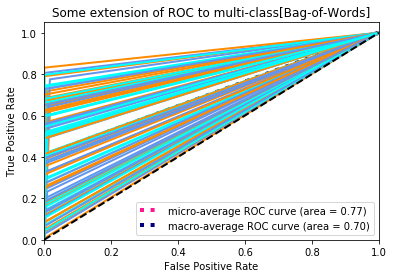

In [49]:
roc_auc_curve_multilabel(y_val,y_val_predicted_labels_mybag,n_classes, 'Bag-of-Words')

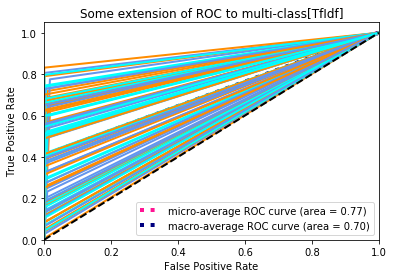

In [50]:
roc_auc_curve_multilabel(y_val,y_val_predicted_labels_mybag,n_classes, 'TfIdf')

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

In [51]:
from sklearn.metrics import f1_score
C_reg=[0.1,0.5,1,5,10,50,100]
f1_score_C=[]
for Creg in C_reg:
    print("Creg=",Creg)
    lr=OneVsRestClassifier(LogisticRegression(penalty='l2',C=Creg,solver='lbfgs',max_iter=1000)).fit(X_train_tfidf, y_train)
    y_val_predicted_labels_tfidf = lr.predict(X_val_tfidf)
    f1score=f1_score(y_val,y_val_predicted_labels_tfidf,average='weighted')  
    print('Tfidf',f1score)
    f1_score_C.append(f1score)


Creg= 0.1


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Tfidf 0.3913644407229134
Creg= 0.5


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Tfidf 0.5736273144543388
Creg= 1
Tfidf 0.6142668931088263
Creg= 5
Tfidf 0.6514579871418036
Creg= 10
Tfidf 0.6540109906751699
Creg= 50
Tfidf 0.6385922606761331
Creg= 100
Tfidf 0.6275850475504303


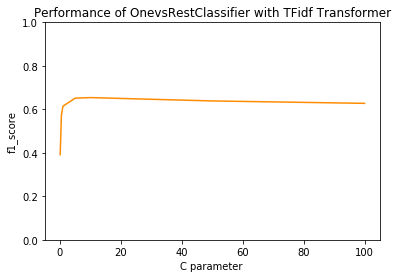

In [52]:
plt.figure()
lw=2
plt.plot(C_reg,f1_score_C, color='darkorange')
plt.ylim([0.0,1.0])
plt.xlabel('C parameter ')
plt.ylabel('f1_score')
plt.title('Performance of OnevsRestClassifier with TFidf Transformer')
plt.show()

In [53]:
######################################
def train_classifier(X_train, y_train, model):
    """
      X_train, y_train — training data  
      return: trained classifier
    """
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    if model=='lr':
        print ("LogisticRegression")
        return OneVsRestClassifier(LogisticRegression( penalty='l2',random_state=0,C=10,solver='lbfgs',max_iter=500)).fit(X_train, y_train)
    elif model=='SVM':
        print("Support Vector Machine")
        return OneVsRestClassifier(LinearSVC()).fit(X_train, y_train)        
    elif model=='MNB':
        print("MultinomialNB")
        return OneVsRestClassifier(MultinomialNB()).fit(X_train, y_train)    
    else:
        pass
    
        

    
######################################

In [54]:
######################################
from sklearn.metrics import f1_score
models=['lr','SVM','MNB']
BOW_score=[]
TFIDF_score=[]
for model in models:
    classifier_mybag = train_classifier(X_train_mybag, y_train,model)
    y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
    f1score=f1_score(y_val, y_val_predicted_labels_mybag,average='weighted')
    BOW_score.append(f1score)
    print('Bag-of-words',f1score)
    classifier_tfidf = train_classifier(X_train_tfidf, y_train,model)
    y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
    g1score=f1_score(y_val,y_val_predicted_labels_tfidf,average='weighted')
    TFIDF_score.append(g1score)
    print('Tfidf',g1score)                                  

LogisticRegression
Bag-of-words 0.6514944359375615
LogisticRegression
Tfidf 0.6540109906751699
Support Vector Machine
Bag-of-words 0.6581060304888663
Support Vector Machine
Tfidf 0.6614169003852886
MultinomialNB
Bag-of-words 0.6296148179299079
MultinomialNB
Tfidf 0.398129431834211


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
classifier_tfidf=OneVsRestClassifier(LinearSVC()).fit(X_train_tfidf, y_train)   
y_val_predict_tfidf=classifier_tfidf.predict(X_val_tfidf)
print(f1_score(y_val,y_val_predict_tfidf,average='weighted'))

0.6614169003852886


When you are happy with the quality, create predictions for *test* set, which you will submit to Coursera.

In [56]:
#test_predictions = ######### YOUR CODE HERE ##########
test_predictions=classifier_tfidf.predict(X_test_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	python
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java,swing
8...


### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [57]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    ######################################
    ######### YOUR CODE HERE #############
    index_tag=tags_classes.index(tag)
    model=classifier.estimators_[index_tag]
    ######################################
    
    #top_positive_words = # top-5 words sorted by the coefficiens.
    top_positive_words=[index_to_words[ii] for ii in model.coef_.argsort().tolist()[0][-5:]]
    #top_negative_words = # bottom-5 words  sorted by the coefficients.
    top_negative_words=[index_to_words[ii] for ii in model.coef_.argsort().tolist()[0][:5]]
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [58]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	printf, fscanf, scanf, malloc, c
Top negative words:	php, java, python, objective c, objective

Tag:	c++
Top positive words:	c++11, mfc, boost, qt, c++
Top negative words:	java, php, c#, python, c++ stl

Tag:	linux
Top positive words:	dlopen, system call, killed, kernel space, linux
Top negative words:	aspnet, nokogiri, codeigniter, implementing, c#



### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [59]:
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	python
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java,swing
8...


In [60]:
STUDENT_EMAIL ="ruperto.bonet@gmail.com"
STUDENT_TOKEN ="RUYziyZLUfFp7LjA"
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	python
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java,swing
8...


If you want to submit these answers, run cell below

In [61]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
